# Predicting Glass Transition Temperature: In-Depth Analysis

This notebook provides a comprehensive analysis of the glass transition temperature (Tg) dataset, with the goal of understanding the factors that influence Tg and building predictive models.

## 1. Setup and Imports

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# For preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

# For feature importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_regression

# For transformations
from sklearn.preprocessing import PowerTransformer

# For visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 2. Dataset Overview

Let's load the dataset and examine its structure.

In [2]:
# Load the dataset
df = pd.read_csv('augment1.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nNumber of features: {df.shape[1] - 1}")
print(f"Number of samples: {df.shape[0]}")

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
df.head()

Dataset shape: (1499, 13)

Number of features: 12
Number of samples: 1499

First 5 rows of the dataset:


polymer_name  \
0  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
1  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
2  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
3  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   
4  5(6)-amino-1-(4'-aminophenyl)-1,3,-trimethylin...   

                                      polymer_smiles solvent_formula  \
0  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...          CH2Cl2   
1  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...          CH2Cl2   
2  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...          CH2Cl2   
3  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...             CO2   
4  *c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(cc1)N3C(=O)c4cc...             CO2   

      solvent_name solvent_smiles       mn     mw     tg   dens  temperature  \
0  dichloromethane          ClCCl  18000.0  80000  593.0  1.238       283.15   
1  dichloromethane          ClCCl  18000.0  80000  593.0  1.238       293.15   
2  dichloromethane          ClCCl  18000.0  80000  593.0  1.238       308.15   
3   carbon dioxide          O=C=O  18000.0  80000  611.0  1.225       296.15   
4   carbon dioxide          O=C=O  18000.0  80000  593.0  1.238       308.15   

   dielectric_constant  branching_index  molar_refractivity  
0                  9.1         1.176351            156.2342  
1                  9.1         1.176351            156.2342  
2                  9.1         1.176351            156.2342  
3                  1.6         1.176351            156.2342  
4                  1.6         1.176351            156.2342

In [3]:
# Check data types and basic statistics
print("Data types:")
df.dtypes

Data types:


polymer_name            object
polymer_smiles          object
solvent_formula         object
solvent_name            object
solvent_smiles          object
mn                     float64
mw                       int64
tg                     float64
dens                   float64
temperature            float64
dielectric_constant    float64
branching_index        float64
molar_refractivity     float64
dtype: object

In [4]:
# Summary statistics
df.describe().T

count           mean            std       min  \
mn                   1499.0  251364.225115  453501.691993  1900.000   
mw                   1499.0  337978.401601  490796.425187  2700.000   
tg                   1499.0     350.604169     130.237546   146.000   
dens                 1499.0       1.086366       0.168109     0.740   
temperature          1499.0     338.174343      49.313976   233.150   
dielectric_constant  1488.0       9.389281      18.454891     1.050   
branching_index      1499.0       2.494152       0.785271     0.000   
molar_refractivity   1499.0      44.764110      40.317980     6.731   

                              25%            50%            75%           max  
mn                   40000.000000  110000.000000  337000.000000  5.000000e+06  
mw                   88000.000000  190000.000000  424000.000000  5.000000e+06  
tg                     238.000000     335.000000     415.000000  7.000000e+02  
dens                     0.954000       1.070000       1.200000  2.175000e+00  
temperature            308.150000     323.000000     353.200000  5.231140e+02  
dielectric_constant      1.600000       1.800000       6.000000  8.010000e+01  
branching_index          1.745413       2.831257       3.143197  3.559682e+00  
molar_refractivity      22.307000      32.696800      40.705000  1.683568e+02

In [5]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

print("Missing values analysis:")
missing_df[missing_df['Missing Values'] > 0]

Missing values analysis:


Missing Values  Percentage (%)
dielectric_constant              11        0.733823

### 2.1 Additional Dataset Visualizations

Let's create some additional visualizations to better understand the dataset.

<Figure size 2000x1500 with 0 Axes>

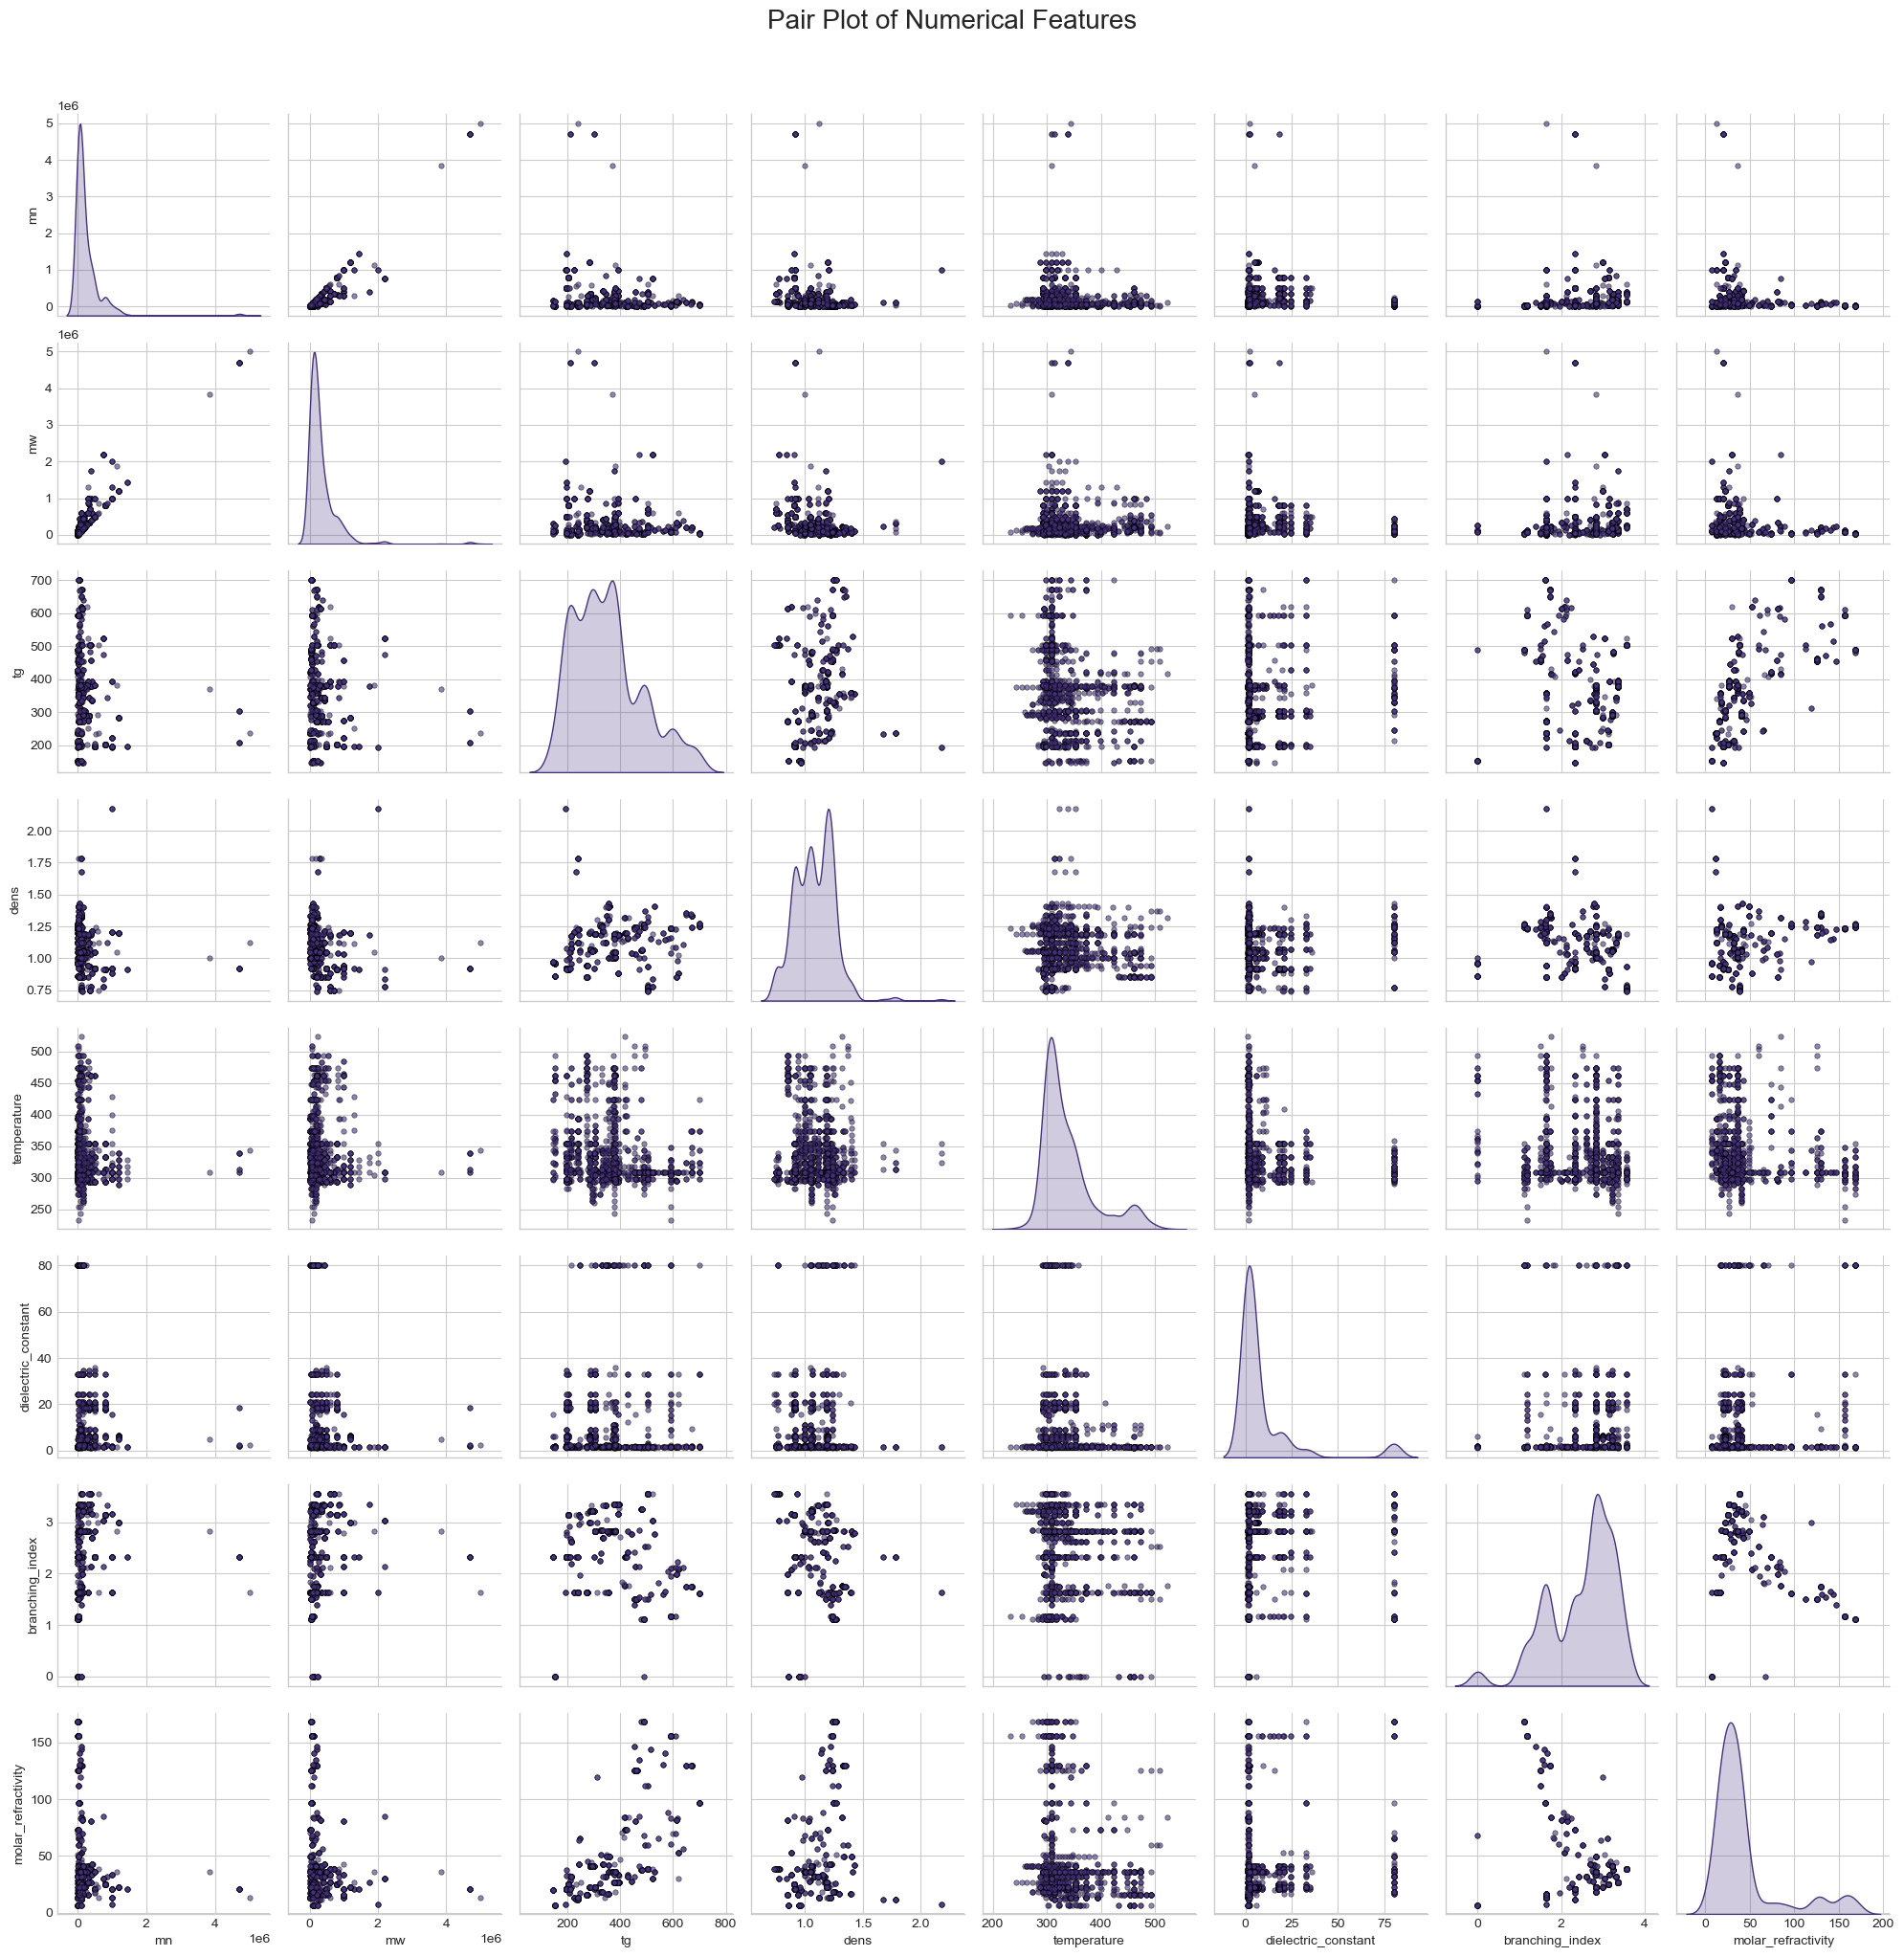

In [6]:
# Create a pair plot for numerical features
numerical_cols = ['mn', 'mw', 'tg', 'dens', 'temperature', 'dielectric_constant', 'branching_index', 'molar_refractivity']
plt.figure(figsize=(20, 15))
sns.pairplot(df[numerical_cols], diag_kind='kde', plot_kws={'alpha': 0.6, 's': 15, 'edgecolor': 'k', 'linewidth': 0.5})
plt.suptitle('Pair Plot of Numerical Features', y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

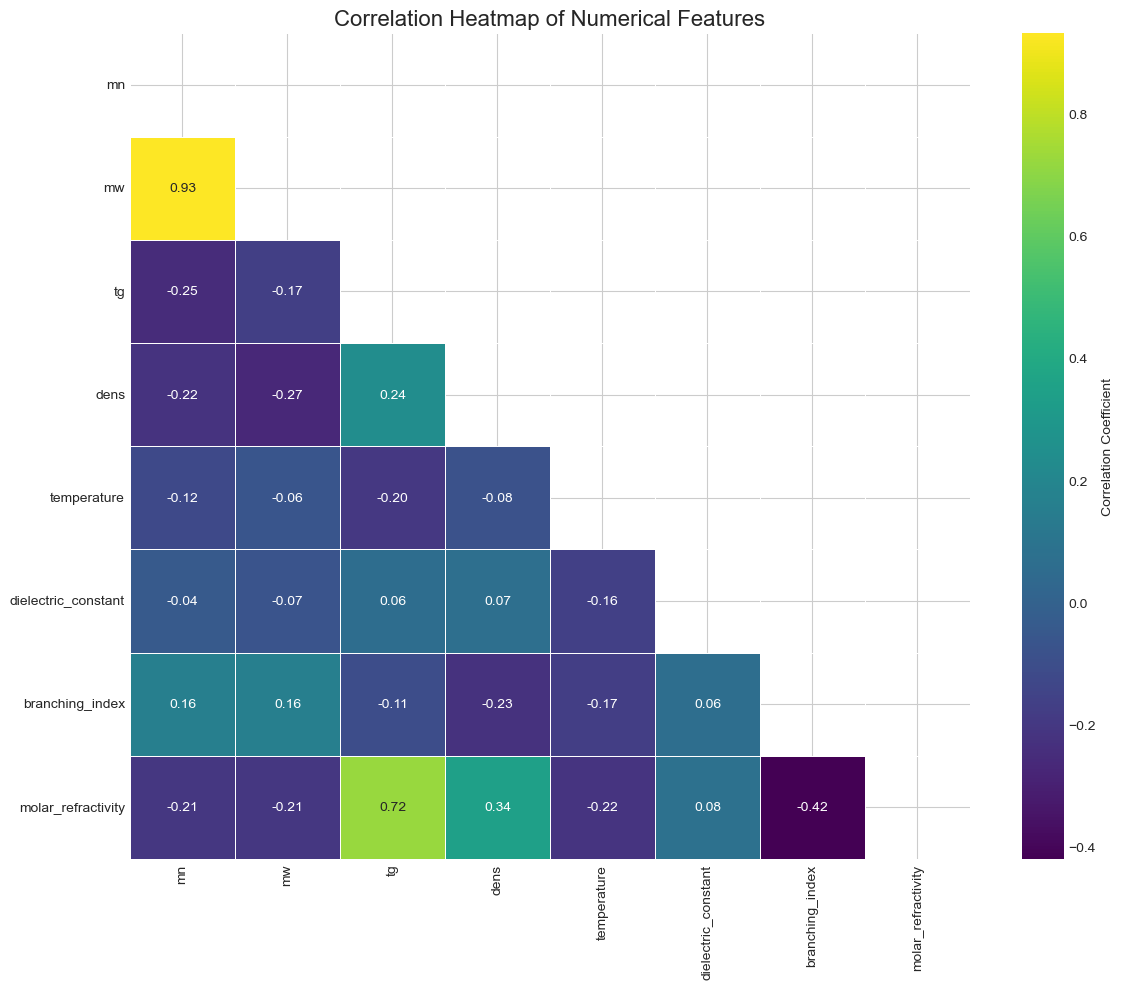

In [7]:
# Create a correlation heatmap
plt.figure(figsize=(12, 10))
corr_matrix = df[numerical_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='viridis', 
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

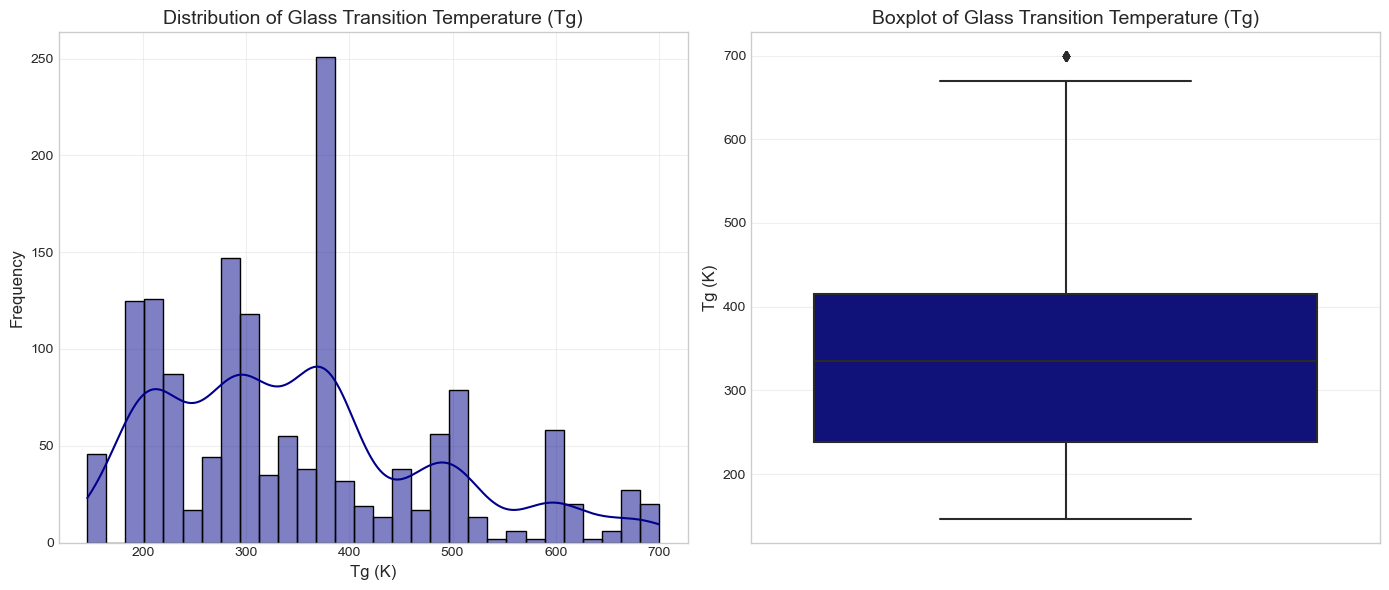

In [8]:
# Distribution of target variable (Tg)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['tg'], kde=True, bins=30, color='darkblue')
plt.title('Distribution of Glass Transition Temperature (Tg)', fontsize=14)
plt.xlabel('Tg (K)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
sns.boxplot(y=df['tg'], color='darkblue')
plt.title('Boxplot of Glass Transition Temperature (Tg)', fontsize=14)
plt.ylabel('Tg (K)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

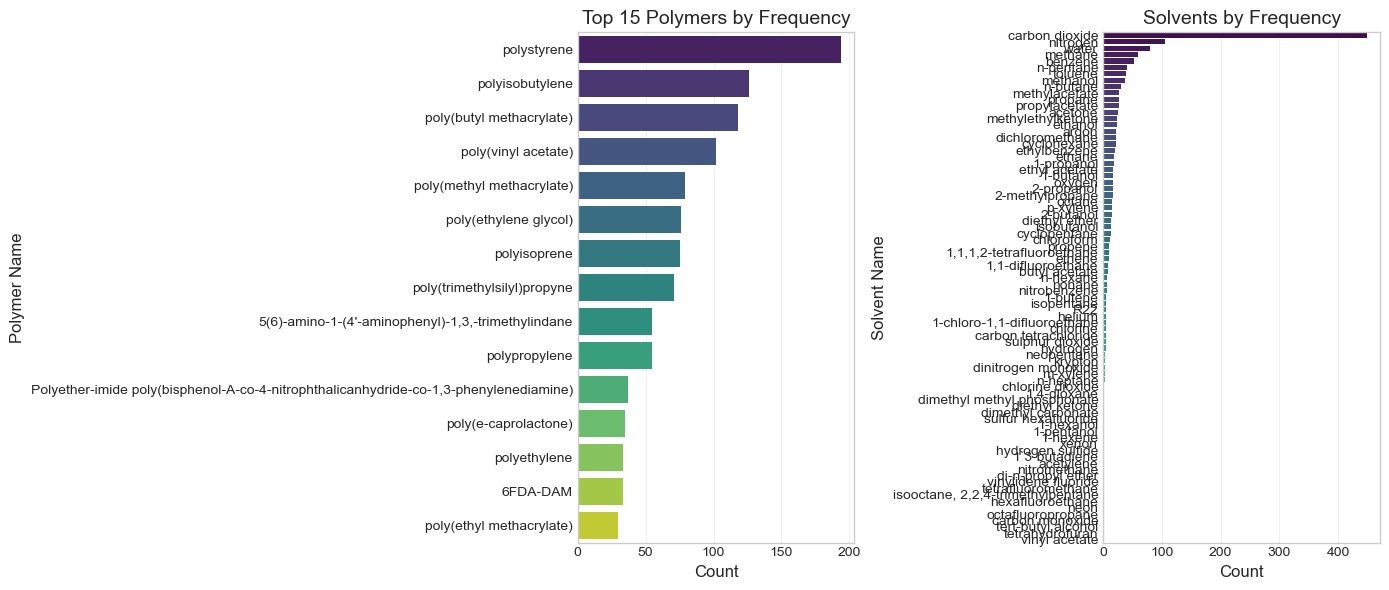

In [9]:
# Count of unique polymers and solvents
plt.figure(figsize=(14, 6))

# Top 15 polymers by frequency
plt.subplot(1, 2, 1)
top_polymers = df['polymer_name'].value_counts().nlargest(15)
sns.barplot(x=top_polymers.values, y=top_polymers.index, palette='viridis')
plt.title('Top 15 Polymers by Frequency', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Polymer Name', fontsize=12)
plt.grid(axis='x', alpha=0.3)

# Solvents by frequency
plt.subplot(1, 2, 2)
solvent_counts = df['solvent_name'].value_counts()
sns.barplot(x=solvent_counts.values, y=solvent_counts.index, palette='viridis')
plt.title('Solvents by Frequency', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Solvent Name', fontsize=12)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

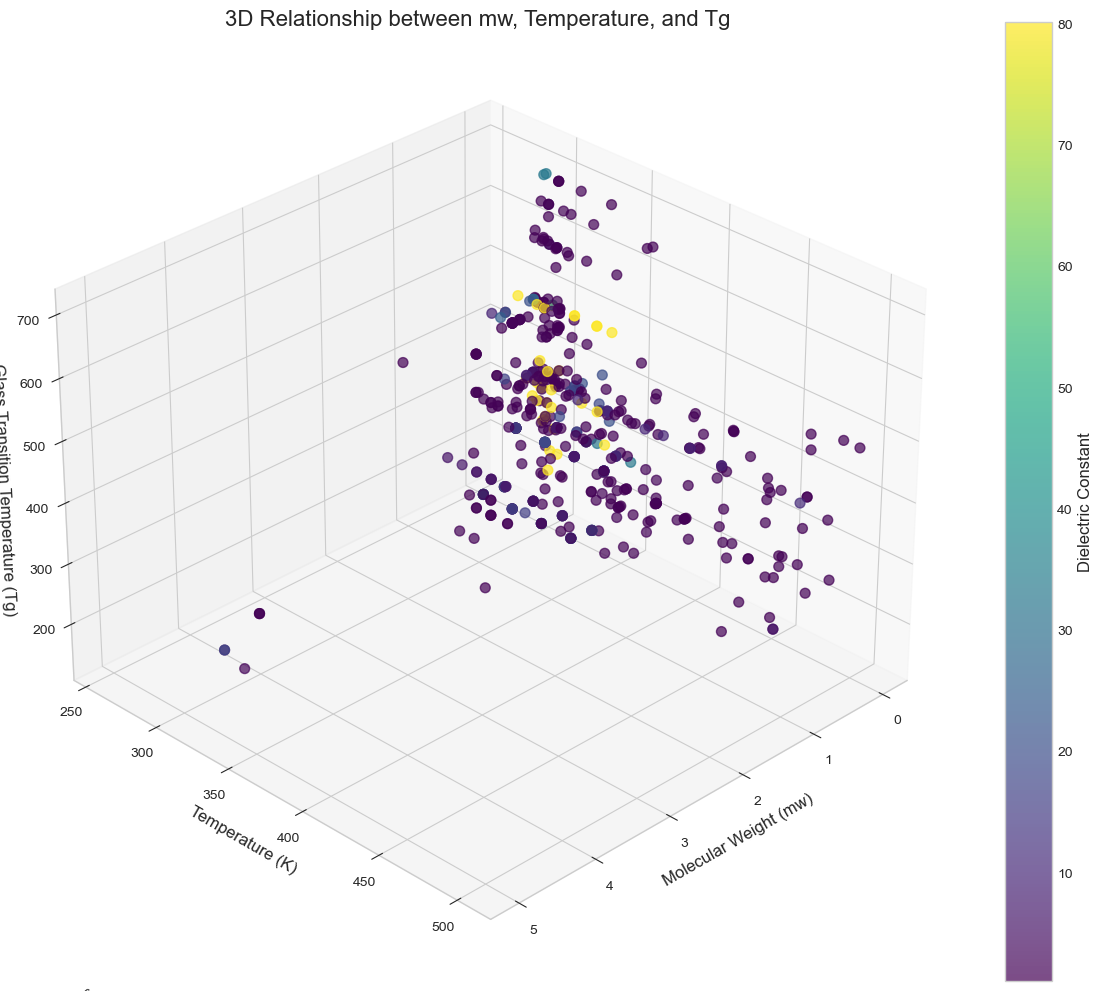

In [10]:
# Advanced visualization: 3D scatter plot of key features
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Sample data (use a subset if the dataset is large)
sample_size = min(500, len(df))
sample_df = df.sample(sample_size, random_state=42)

scatter = ax.scatter(sample_df['mw'], 
                     sample_df['temperature'], 
                     sample_df['tg'],
                     c=sample_df['dielectric_constant'], 
                     cmap='viridis', 
                     s=50, 
                     alpha=0.7)

ax.set_xlabel('Molecular Weight (mw)', fontsize=12)
ax.set_ylabel('Temperature (K)', fontsize=12)
ax.set_zlabel('Glass Transition Temperature (Tg)', fontsize=12)
ax.set_title('3D Relationship between mw, Temperature, and Tg', fontsize=16)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Dielectric Constant', fontsize=12)

# Adjust the viewing angle
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

### 3.1 Handling Missing Values

In [11]:
# Identify columns with missing values
columns_with_missing = missing_df[missing_df['Missing Values'] > 0].index.tolist()

if columns_with_missing:
    print(f"Columns with missing values: {columns_with_missing}")
    
    # Separate numerical and categorical columns with missing values
    numerical_cols = df[columns_with_missing].select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df[columns_with_missing].select_dtypes(include=['object']).columns.tolist()
    
    # For numerical columns, use KNN imputation
    if numerical_cols:
        print(f"\nImputing numerical columns: {numerical_cols}")
        # Create a copy of the dataframe for imputation
        df_numeric = df.copy()
        
        # Select only numeric columns for KNN imputation
        numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        
        # Apply KNN imputation
        imputer = KNNImputer(n_neighbors=5)
        df_numeric[numeric_features] = imputer.fit_transform(df[numeric_features])
        
        # Update the original dataframe with imputed values
        for col in numerical_cols:
            df[col] = df_numeric[col]
    
    # For categorical columns, use mode imputation
    if categorical_cols:
        print(f"\nImputing categorical columns: {categorical_cols}")
        for col in categorical_cols:
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
            print(f"  - {col}: Filled with mode value '{mode_value}'")
else:
    print("No missing values found in the dataset.")

Columns with missing values: ['dielectric_constant']

Imputing numerical columns: ['dielectric_constant']


### 3.2 Checking for Duplicates

In [12]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    # Remove duplicates
    df = df.drop_duplicates()
    print(f"Duplicates removed. New dataset shape: {df.shape}")

Number of duplicate rows: 27
Duplicates removed. New dataset shape: (1472, 13)


### 3.3 Outlier Detection and Handling

We'll use multiple methods to detect outliers in the numerical features.

In [ ]:
# Select numerical columns for outlier detection
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create a copy of the dataframe for outlier analysis
df_outlier = df.copy()

# Function to detect outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Function to detect outliers using Z-score method
def detect_outliers_zscore(df, column, threshold=3):
    iqr_outliers, lower, upper = detect_outliers_iqr(df, col)
    iqr_count = len(iqr_outliers)
    z_scores = np.abs(stats.zscore(df[column]))
    outliers = df[z_scores > threshold]
    return outliers

# Analyze outliers for each numerical column
outlier_summary = {}

for col in numerical_cols:
    # Skip non-continuous variables
    if df[col].nunique() < 10:
        continue
        
    # IQR method
    iqr_outliers, lower, upper = detect_outliers_iqr(df, col)
    iqr_count = len(iqr_outliers)
    
    # Z-score method
    zscore_outliers = detect_outliers_zscore(df, col)
    zscore_count = len(zscore_outliers)
    
    # Store results
    outlier_summary[col] = {
        'IQR': iqr_count,
        'Z-score': zscore_count,
        'IQR_bounds': (lower, upper)
    }

# Display outlier summary
outlier_df = pd.DataFrame({
    'IQR Method': [outlier_summary[col]['IQR'] for col in outlier_summary],
    'Z-score Method': [outlier_summary[col]['Z-score'] for col in outlier_summary],
    'IQR Lower Bound': [outlier_summary[col]['IQR_bounds'][0] for col in outlier_summary],
    'IQR Upper Bound': [outlier_summary[col]['IQR_bounds'][1] for col in outlier_summary]
}, index=outlier_summary.keys())

print("Outlier Detection Summary:")
outlier_df

Outlier Detection Summary:


IQR Method  Z-score Method  IQR Lower Bound  \
mn                          143              10   -405500.000000   
mw                          107              24   -414062.500000   
tg                           52               0         5.500000   
dens                         13              13         0.557500   
temperature                 161              15       240.575000   
dielectric_constant         279              78        -5.000000   
branching_index               0              34        -0.311746   
molar_refractivity          221              37        -9.777500   

                     IQR Upper Bound  
mn                     782500.000000  
mw                     926837.500000  
tg                        625.500000  
dens                        1.577500  
temperature               420.775000  
dielectric_constant        12.600000  
branching_index             5.216163  
molar_refractivity         70.994500

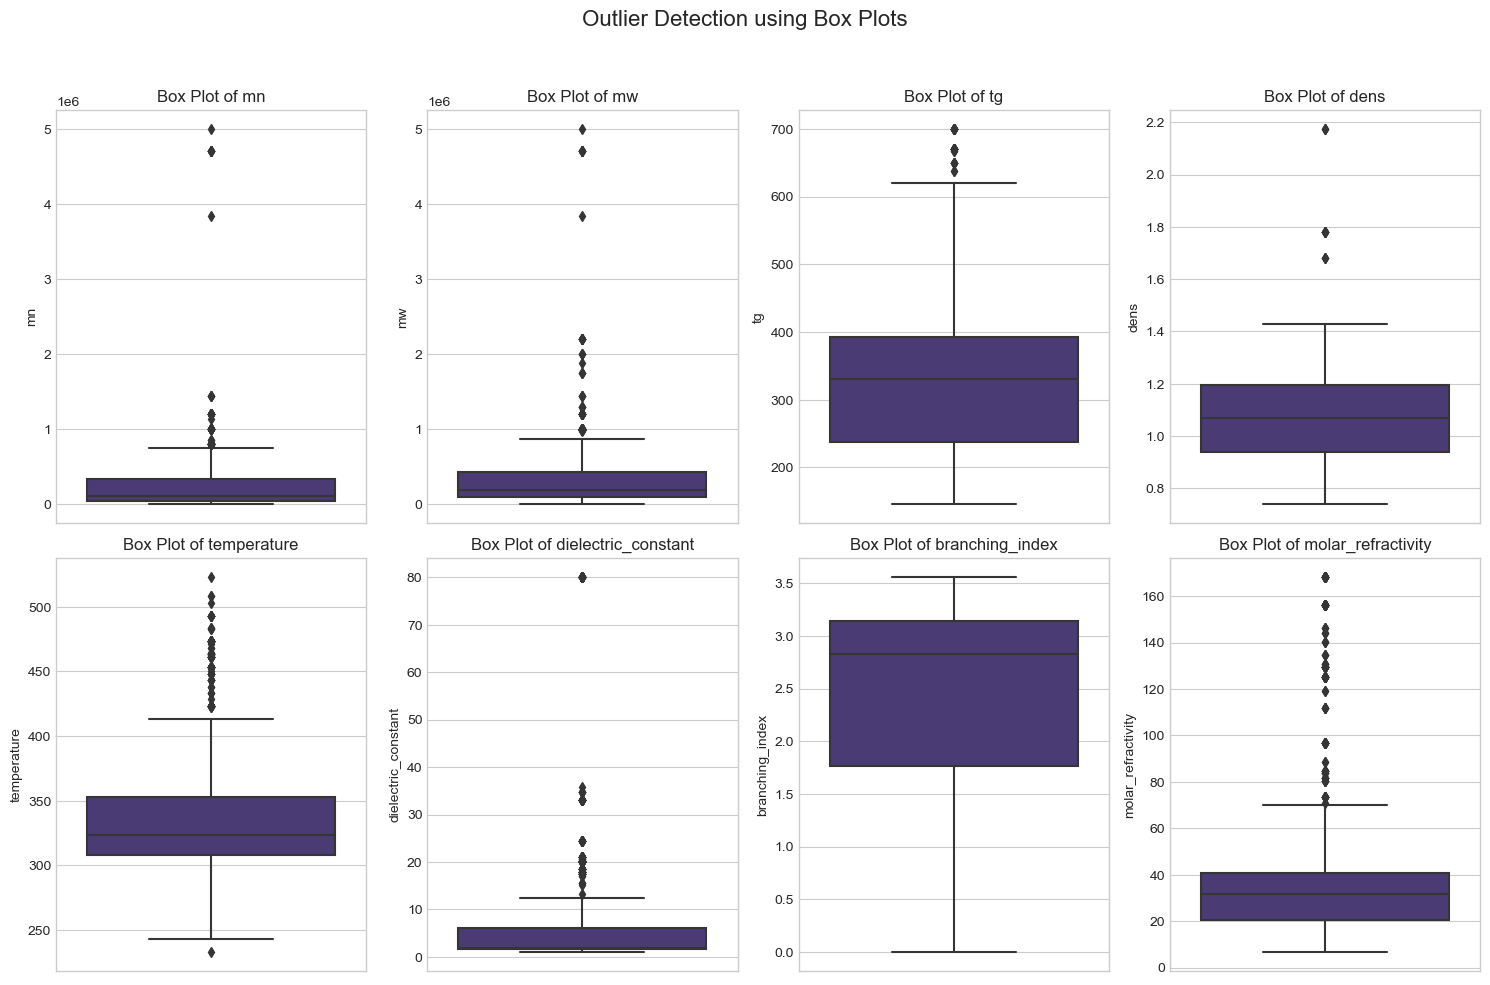

In [14]:
# Visualize outliers using box plots for key numerical features
plt.figure(figsize=(15, 10))

# Select important numerical columns for visualization
key_numerical_cols = ['mn', 'mw', 'tg', 'dens', 'temperature', 'dielectric_constant', 'branching_index', 'molar_refractivity']
key_numerical_cols = [col for col in key_numerical_cols if col in df.columns]

for i, col in enumerate(key_numerical_cols):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.tight_layout()

plt.suptitle('Outlier Detection using Box Plots', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [15]:
# Handle outliers using capping method for extreme values
# We'll cap values at the IQR bounds to preserve data while reducing extreme values

df_cleaned = df.copy()

for col in outlier_summary:
    lower_bound = outlier_summary[col]['IQR_bounds'][0]
    upper_bound = outlier_summary[col]['IQR_bounds'][1]
    
    # Count values outside bounds
    lower_count = (df_cleaned[col] < lower_bound).sum()
    upper_count = (df_cleaned[col] > upper_bound).sum()
    
    # Only cap if outliers are less than 5% of the data
    total_outliers = lower_count + upper_count
    if total_outliers > 0 and total_outliers < 0.05 * len(df_cleaned):
        print(f"Capping outliers in {col}: {lower_count} below lower bound, {upper_count} above upper bound")
        
        # Cap values
        df_cleaned[col] = df_cleaned[col].clip(lower=lower_bound, upper=upper_bound)
    elif total_outliers >= 0.05 * len(df_cleaned):
        print(f"Not capping {col}: too many outliers ({total_outliers}, {total_outliers/len(df_cleaned)*100:.2f}%)")

# Use the cleaned dataframe for further analysis
df = df_cleaned

Not capping mn: too many outliers (143, 9.71%)
Not capping mw: too many outliers (107, 7.27%)
Capping outliers in tg: 0 below lower bound, 52 above upper bound
Capping outliers in dens: 0 below lower bound, 13 above upper bound
Not capping temperature: too many outliers (161, 10.94%)
Not capping dielectric_constant: too many outliers (279, 18.95%)
Not capping molar_refractivity: too many outliers (221, 15.01%)


### 3.4 Scaling and Standardization

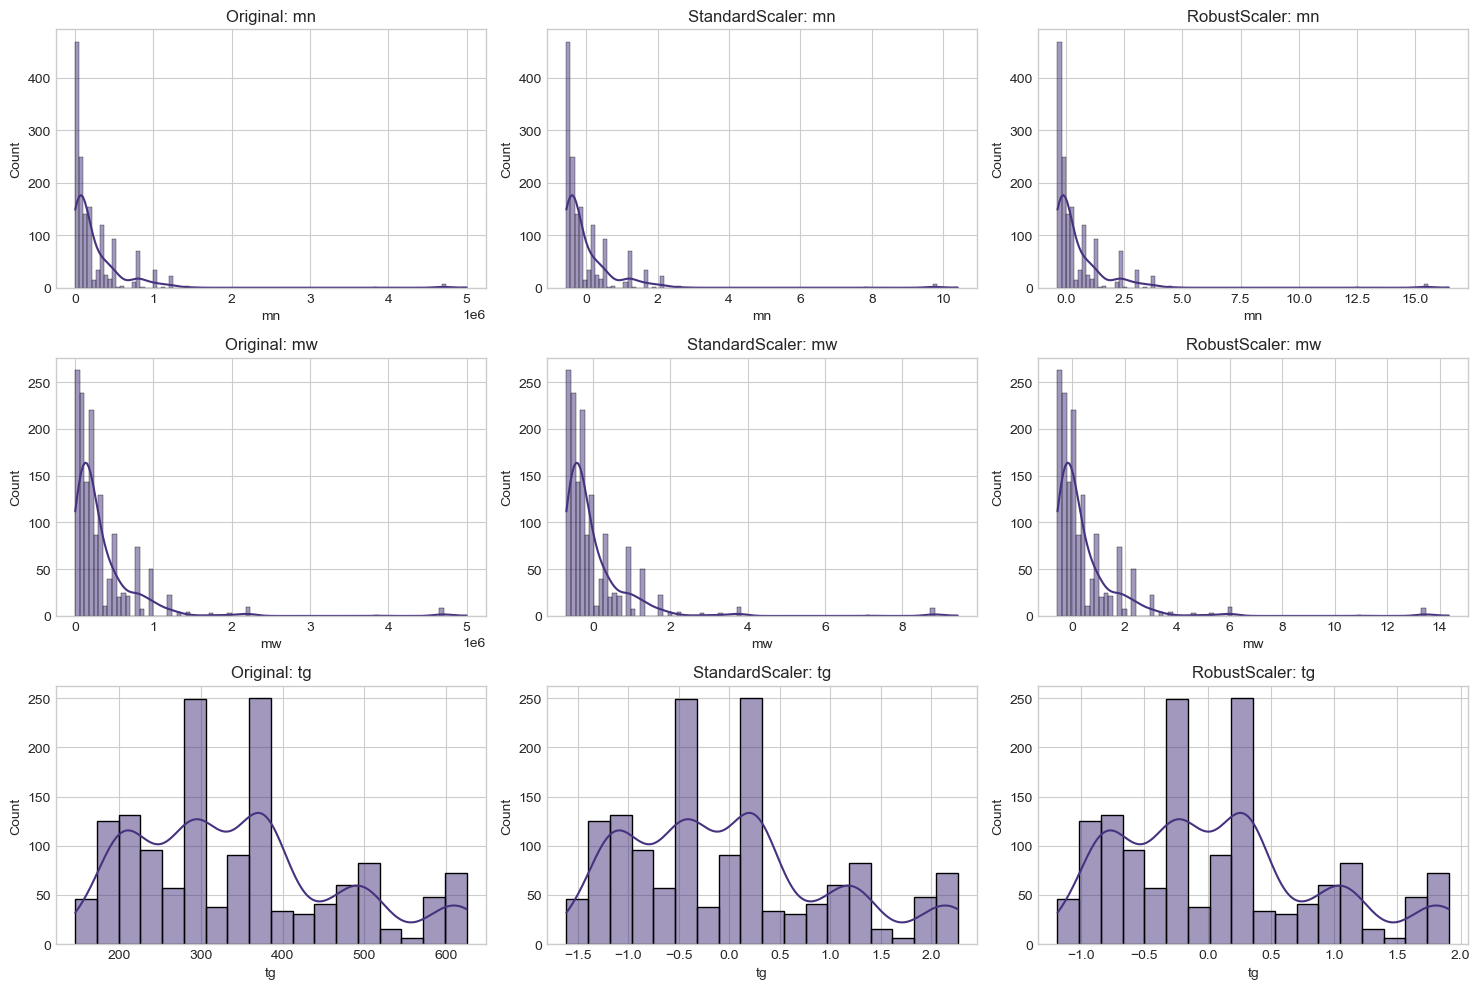

In [16]:
# Select numerical columns for scaling
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create copies of the dataframe with different scaling methods
df_standard = df.copy()
df_minmax = df.copy()
df_robust = df.copy()

# Apply StandardScaler
std_scaler = StandardScaler()
df_standard[numerical_cols] = std_scaler.fit_transform(df[numerical_cols])

# Apply MinMaxScaler
minmax_scaler = MinMaxScaler()
df_minmax[numerical_cols] = minmax_scaler.fit_transform(df[numerical_cols])

# Apply RobustScaler (less sensitive to outliers)
robust_scaler = RobustScaler()
df_robust[numerical_cols] = robust_scaler.fit_transform(df[numerical_cols])

# Compare the scaling methods for a few columns
sample_cols = ['mn', 'mw', 'tg'] if all(col in numerical_cols for col in ['mn', 'mw', 'tg']) else numerical_cols[:3]

plt.figure(figsize=(15, 10))

for i, col in enumerate(sample_cols):
    plt.subplot(3, 3, i*3+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Original: {col}')
    
    plt.subplot(3, 3, i*3+2)
    sns.histplot(df_standard[col], kde=True)
    plt.title(f'StandardScaler: {col}')
    
    plt.subplot(3, 3, i*3+3)
    sns.histplot(df_robust[col], kde=True)
    plt.title(f'RobustScaler: {col}')

plt.tight_layout()
plt.show()

# Based on the presence of outliers, we'll use RobustScaler for further analysis
# as it's less sensitive to outliers
df_scaled = df_robust

## 4. Exploratory Data Analysis (EDA)

### 4.1 Univariate Analysis

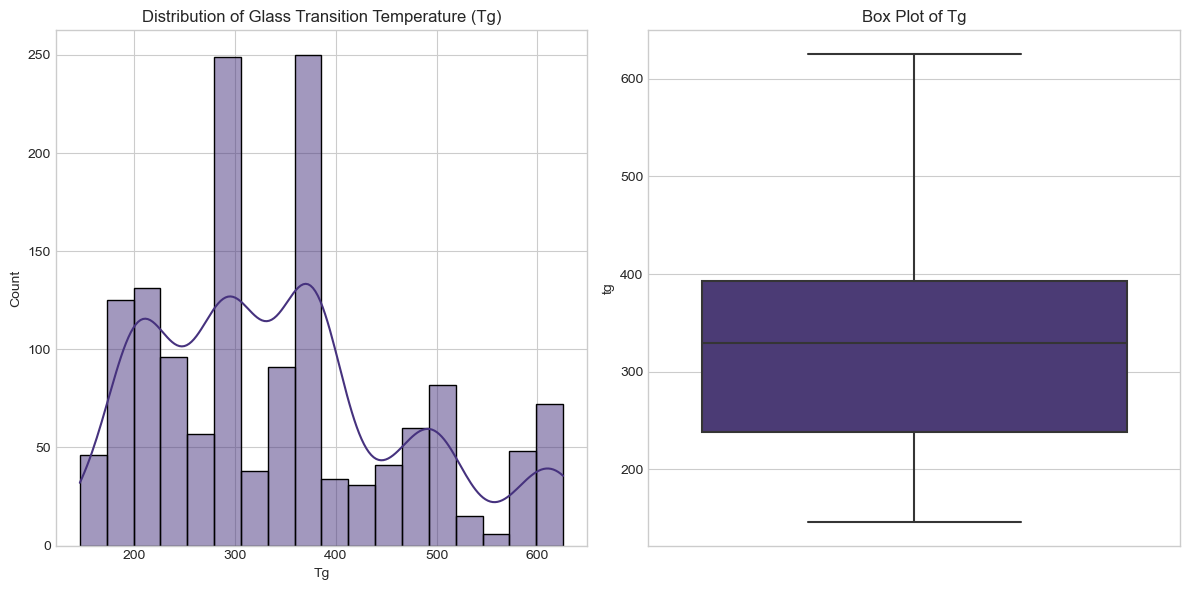

Tg Skewness: 0.6054
Tg Kurtosis: -0.3723


In [17]:
# Analyze the distribution of the target variable (Tg)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['tg'], kde=True)
plt.title('Distribution of Glass Transition Temperature (Tg)')
plt.xlabel('Tg')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['tg'])
plt.title('Box Plot of Tg')

plt.tight_layout()
plt.show()

# Calculate skewness and kurtosis of Tg
tg_skewness = df['tg'].skew()
tg_kurtosis = df['tg'].kurt()

print(f"Tg Skewness: {tg_skewness:.4f}")
print(f"Tg Kurtosis: {tg_kurtosis:.4f}")

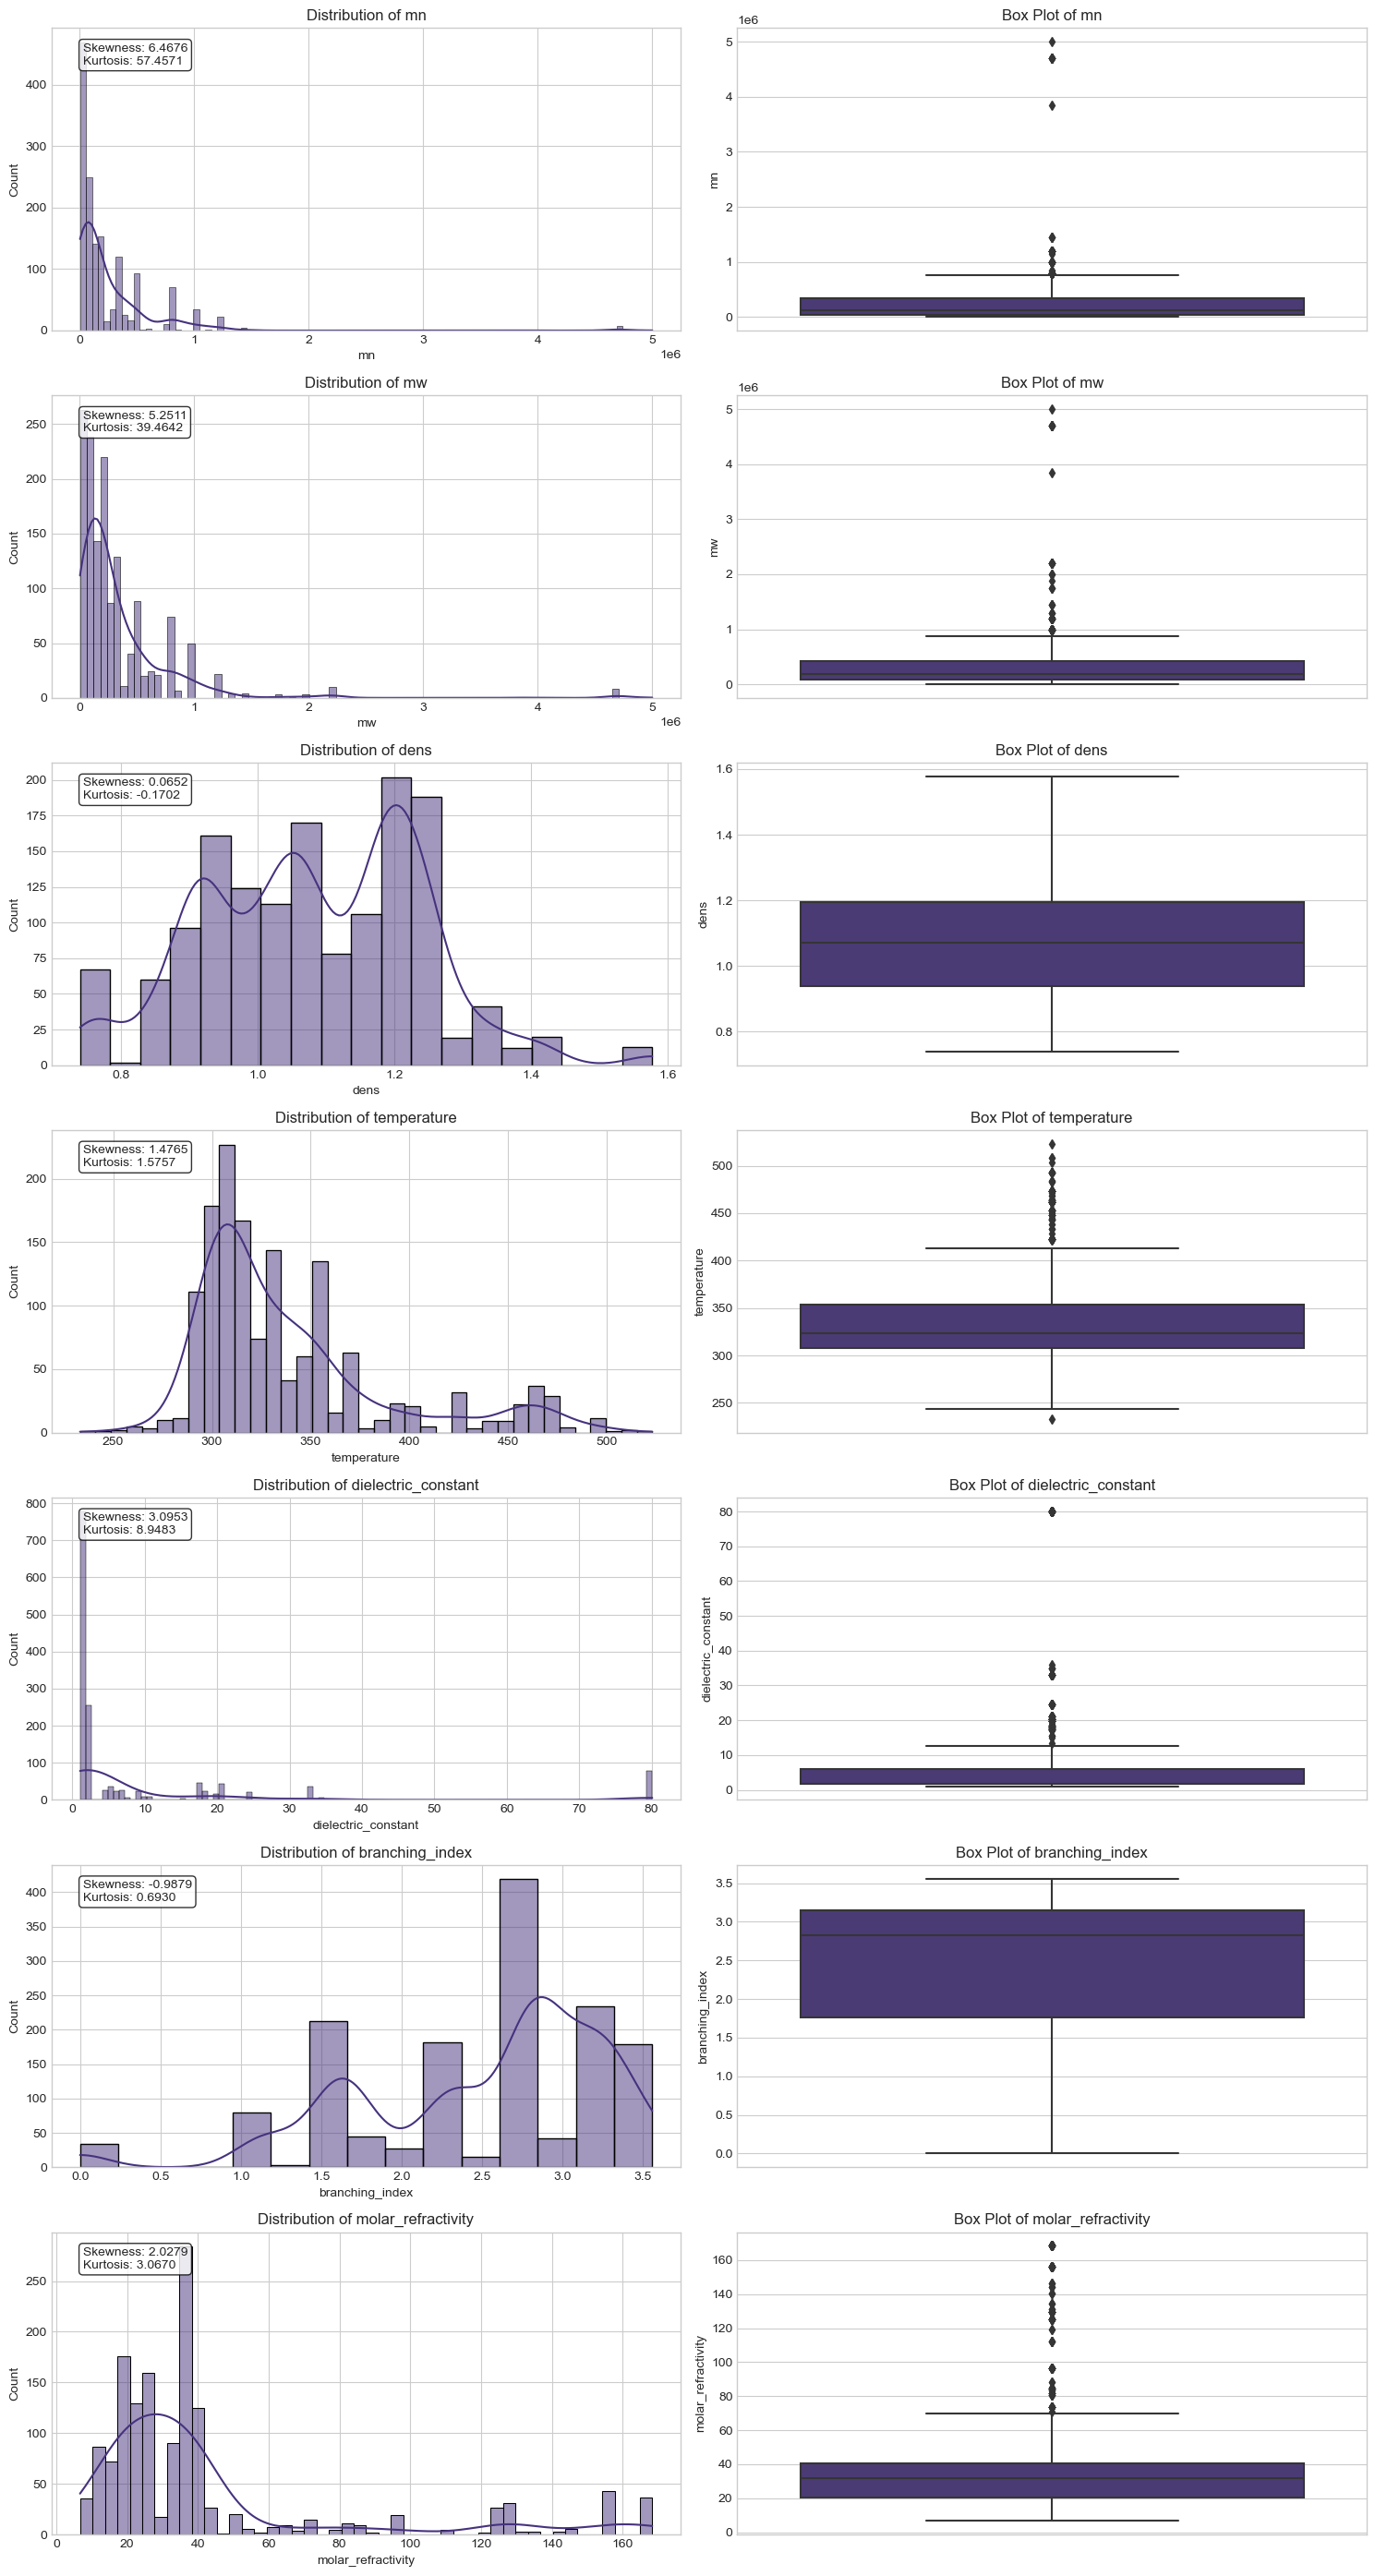

In [18]:
# Analyze distributions of key numerical features
numerical_features = ['mn', 'mw', 'dens', 'temperature', 'dielectric_constant', 'branching_index', 'molar_refractivity']
numerical_features = [col for col in numerical_features if col in df.columns]

# Create histograms and density plots
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(15, 4*len(numerical_features)))

for i, feature in enumerate(numerical_features):
    # Histogram with KDE
    sns.histplot(df[feature], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {feature}')
    
    # Box plot
    sns.boxplot(y=df[feature], ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {feature}')
    
    # Calculate and display skewness and kurtosis
    skewness = df[feature].skew()
    kurtosis = df[feature].kurt()
    axes[i, 0].text(0.05, 0.95, f"Skewness: {skewness:.4f}\nKurtosis: {kurtosis:.4f}", 
                   transform=axes[i, 0].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

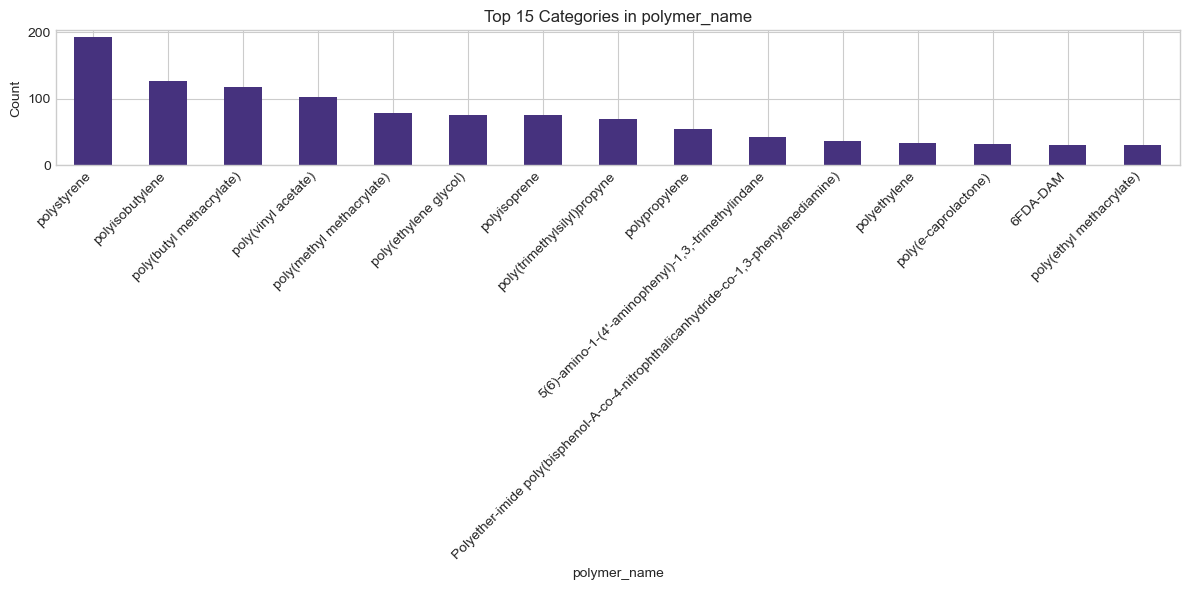

polymer_name has 83 unique values. Showing top 15.


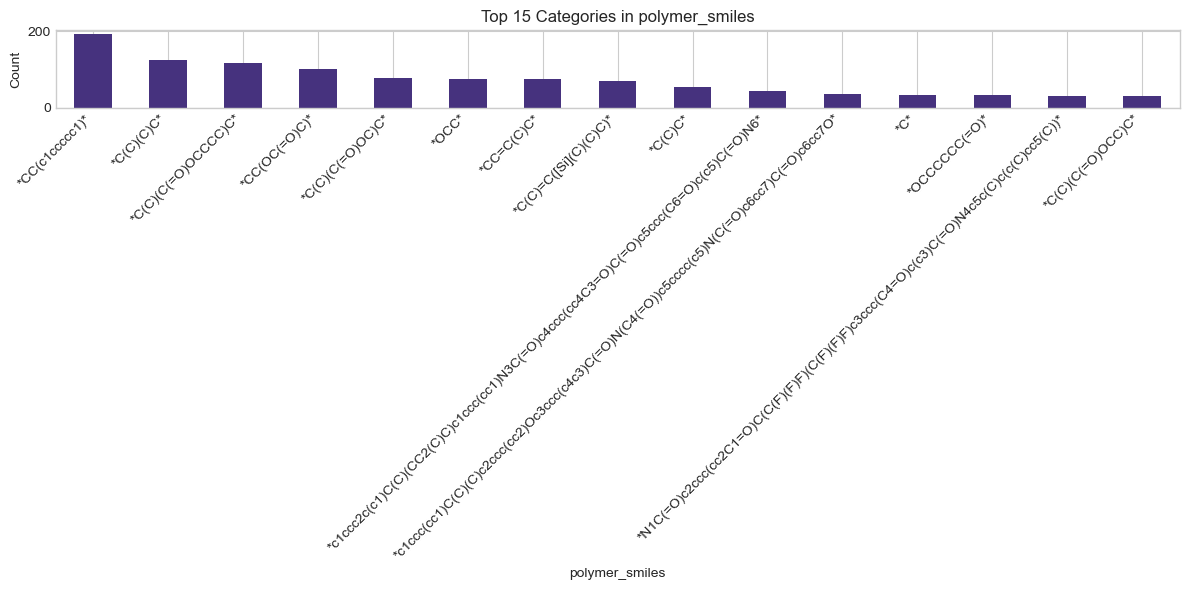

polymer_smiles has 83 unique values. Showing top 15.


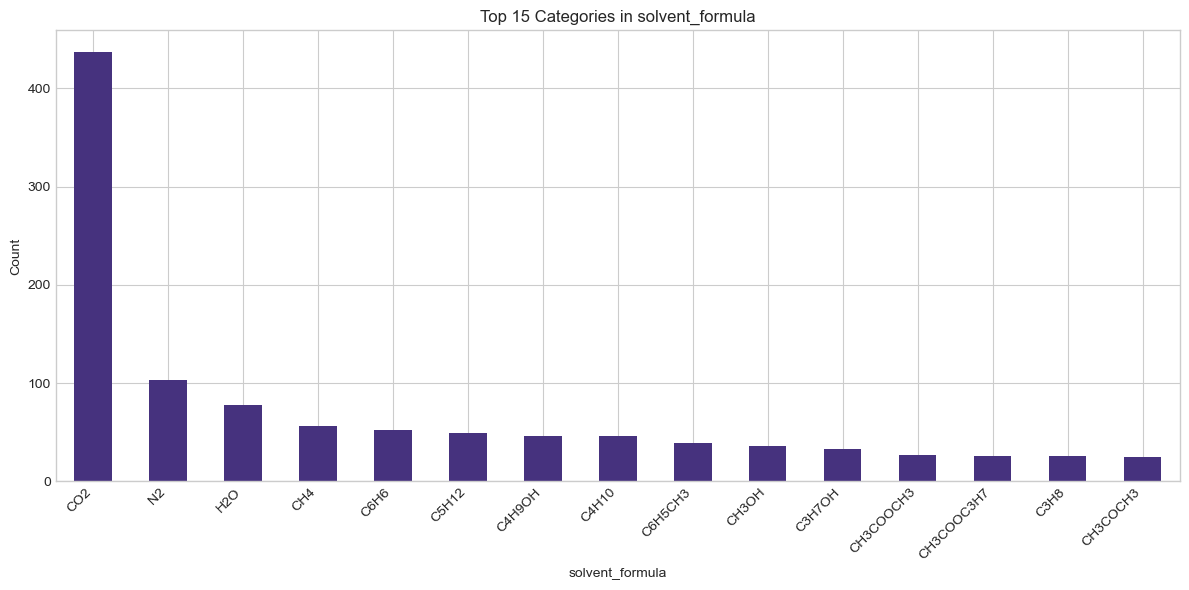

solvent_formula has 70 unique values. Showing top 15.


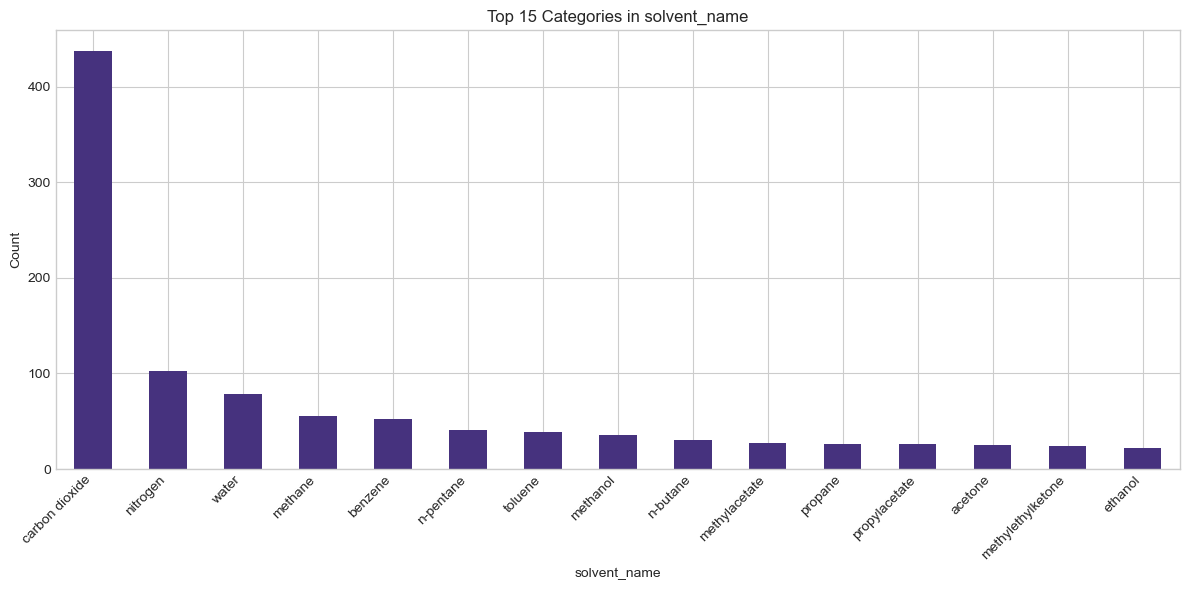

solvent_name has 80 unique values. Showing top 15.


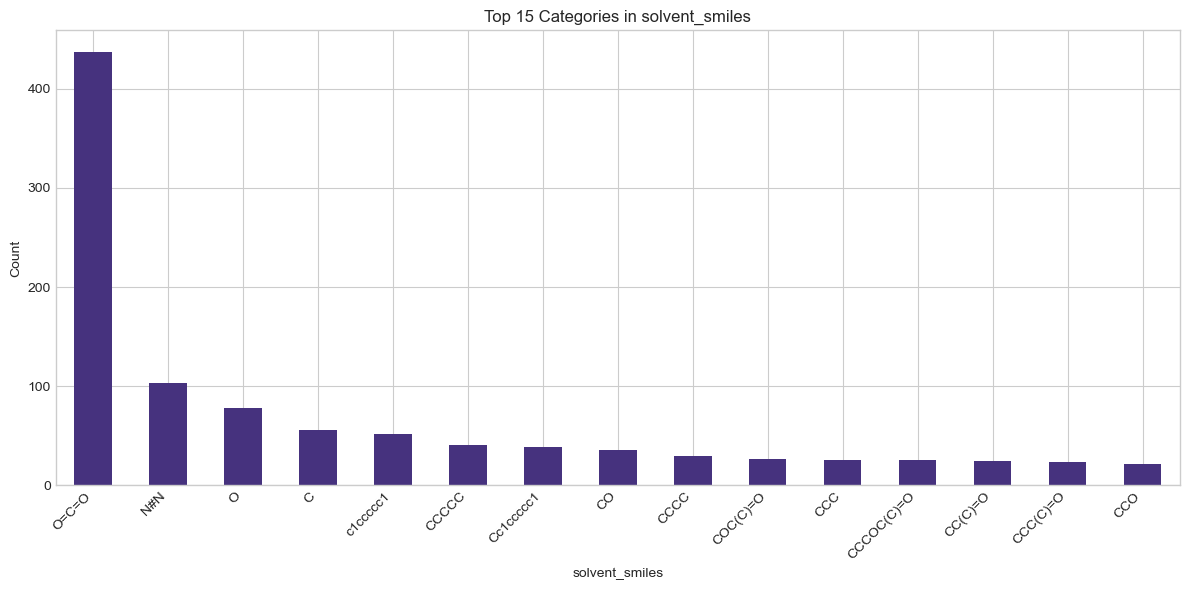

solvent_smiles has 80 unique values. Showing top 15.


In [19]:
# Analyze categorical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

if categorical_features:
    for feature in categorical_features:
        # Count the frequency of each category
        value_counts = df[feature].value_counts()
        
        # If there are too many categories, show only the top 15
        if len(value_counts) > 15:
            plt.figure(figsize=(12, 6))
            value_counts.nlargest(15).plot(kind='bar')
            plt.title(f'Top 15 Categories in {feature}')
            plt.xlabel(feature)
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            print(f"{feature} has {len(value_counts)} unique values. Showing top 15.")
        else:
            plt.figure(figsize=(12, 6))
            value_counts.plot(kind='bar')
            plt.title(f'Categories in {feature}')
            plt.xlabel(feature)
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
else:
    print("No categorical features found in the dataset.")

### 4.2 Bivariate and Multivariate Analysis

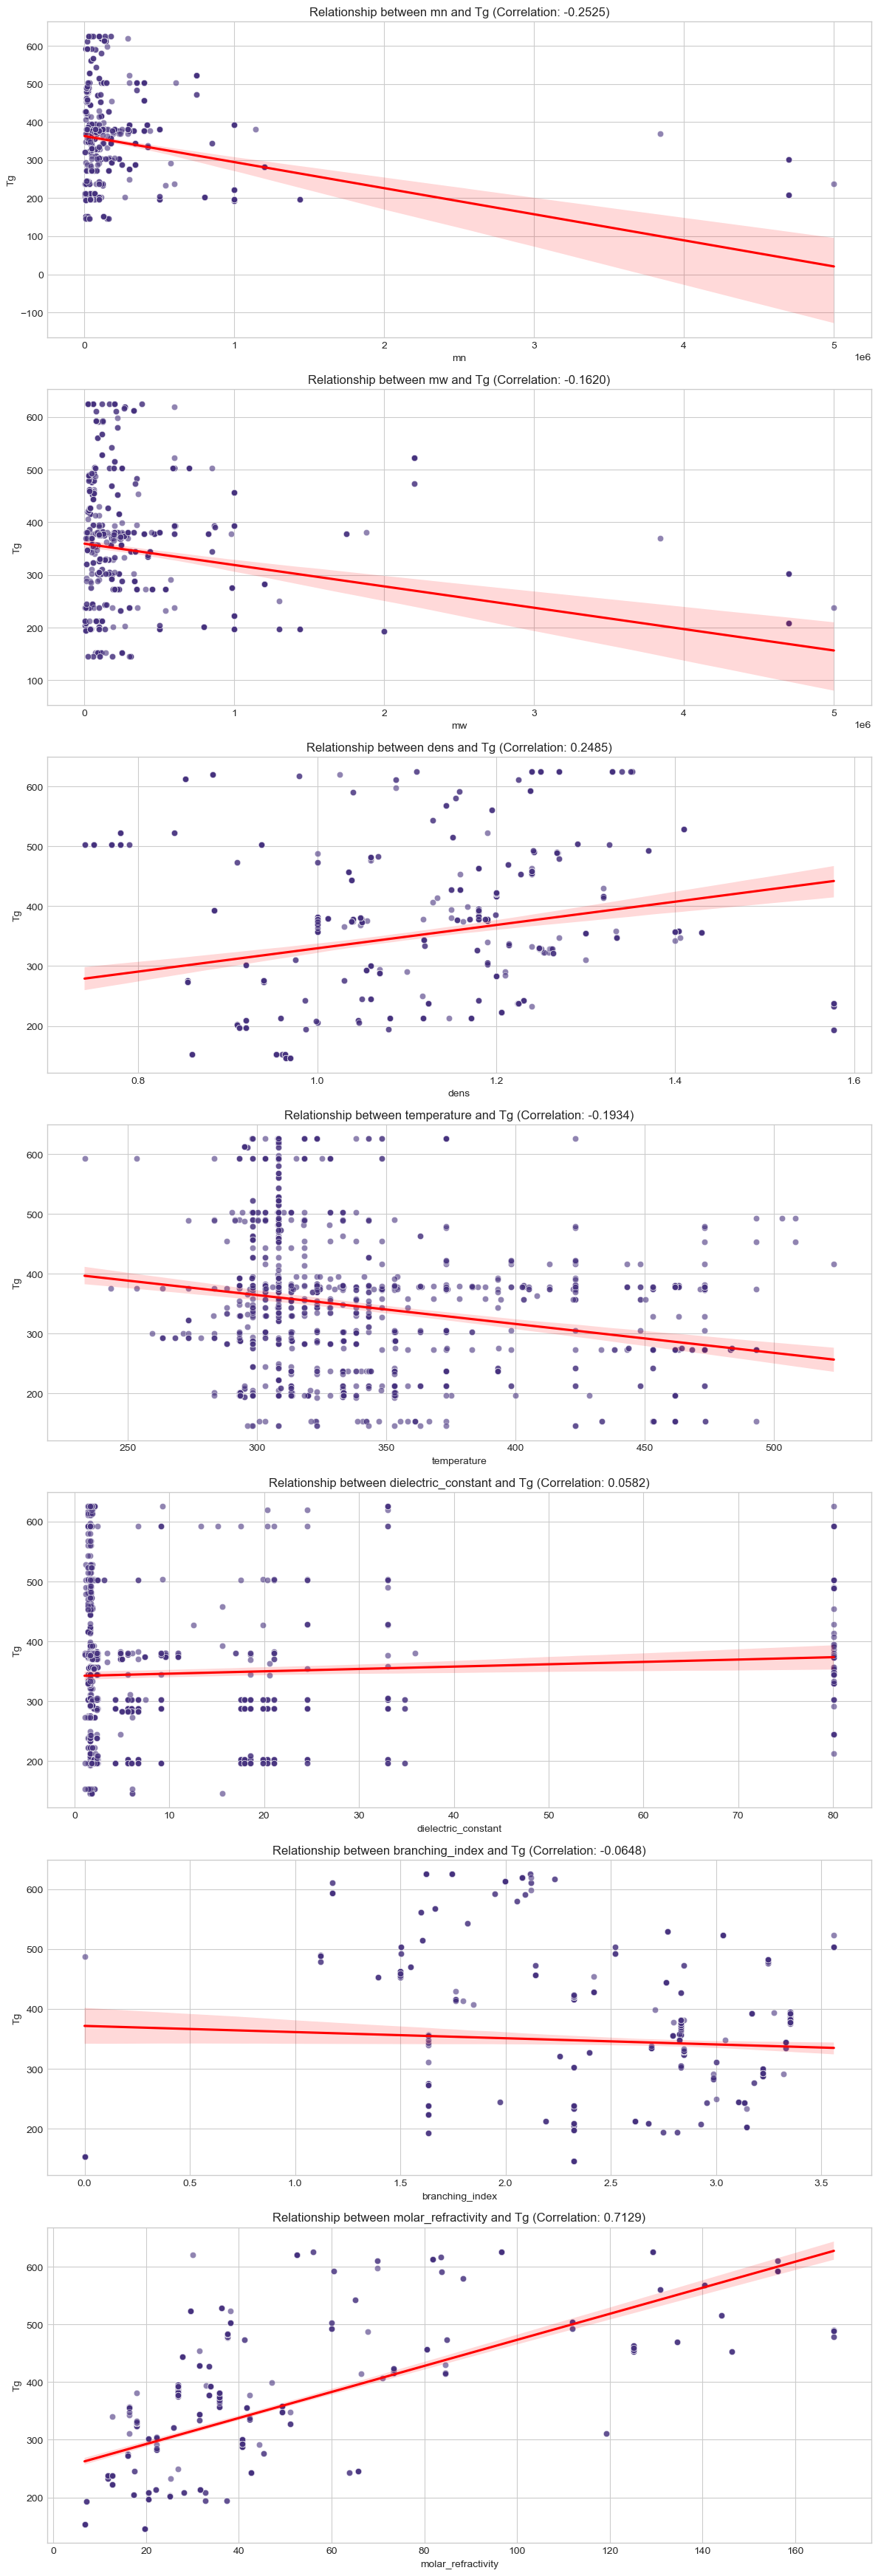

In [20]:
# Analyze relationships between numerical features and Tg
numerical_features = [col for col in numerical_cols if col != 'tg']

# Create scatter plots for each numerical feature vs Tg
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(12, 5*len(numerical_features)))

for i, feature in enumerate(numerical_features):
    sns.scatterplot(x=df[feature], y=df['tg'], alpha=0.6, ax=axes[i])
    
    # Add regression line
    sns.regplot(x=df[feature], y=df['tg'], scatter=False, ax=axes[i], color='red')
    
    # Calculate correlation coefficient
    corr = df[[feature, 'tg']].corr().iloc[0, 1]
    axes[i].set_title(f'Relationship between {feature} and Tg (Correlation: {corr:.4f})')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Tg')

plt.tight_layout()
plt.show()

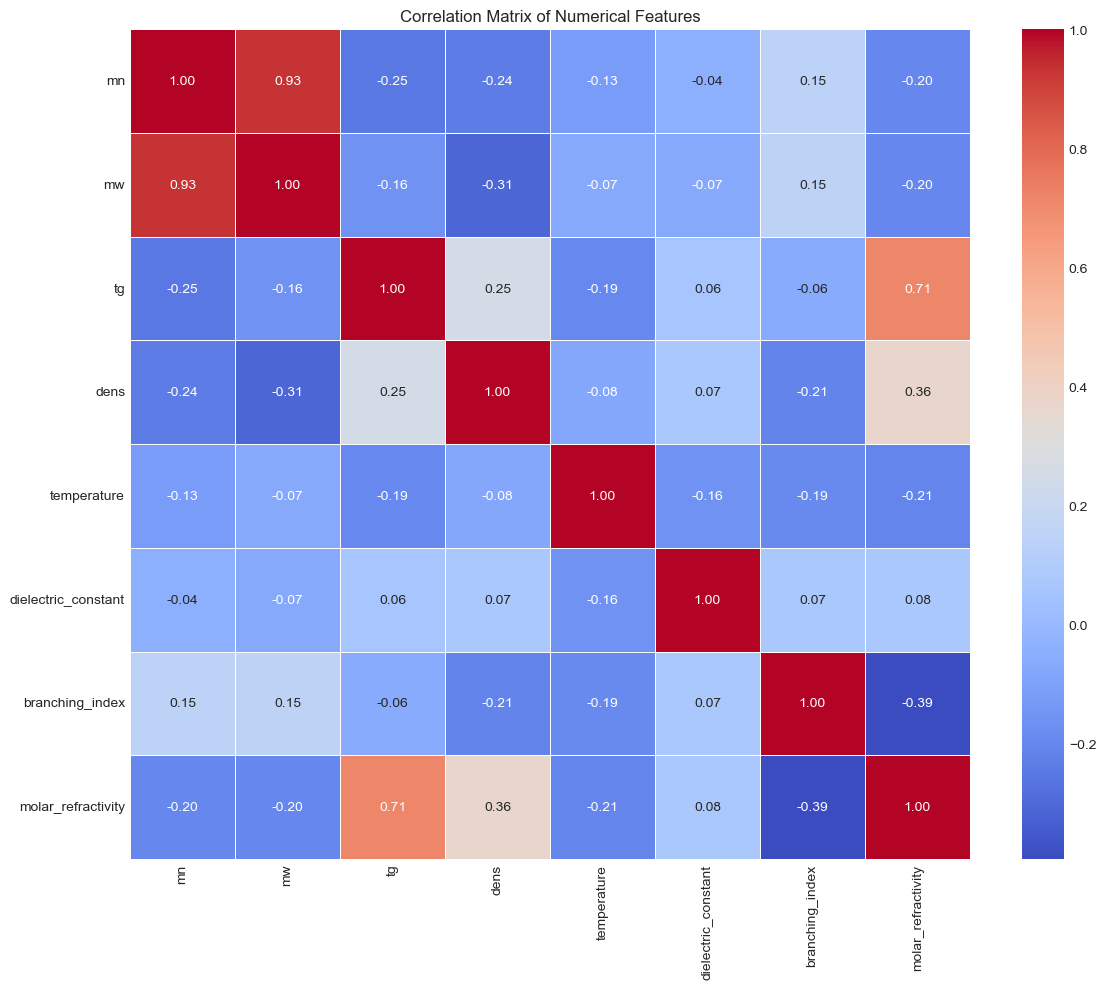

Highly correlated features (|correlation| > 0.7):
mw and mn: 0.9308
molar_refractivity and tg: 0.7129


In [21]:
# Correlation matrix for numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
correlation_matrix = df[numerical_features].corr()

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Identify highly correlated features (|correlation| > 0.7)
high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

if high_corr:
    print("Highly correlated features (|correlation| > 0.7):")
    for feat1, feat2, corr in high_corr:
        print(f"{feat1} and {feat2}: {corr:.4f}")
else:
    print("No highly correlated features found (|correlation| > 0.7).")

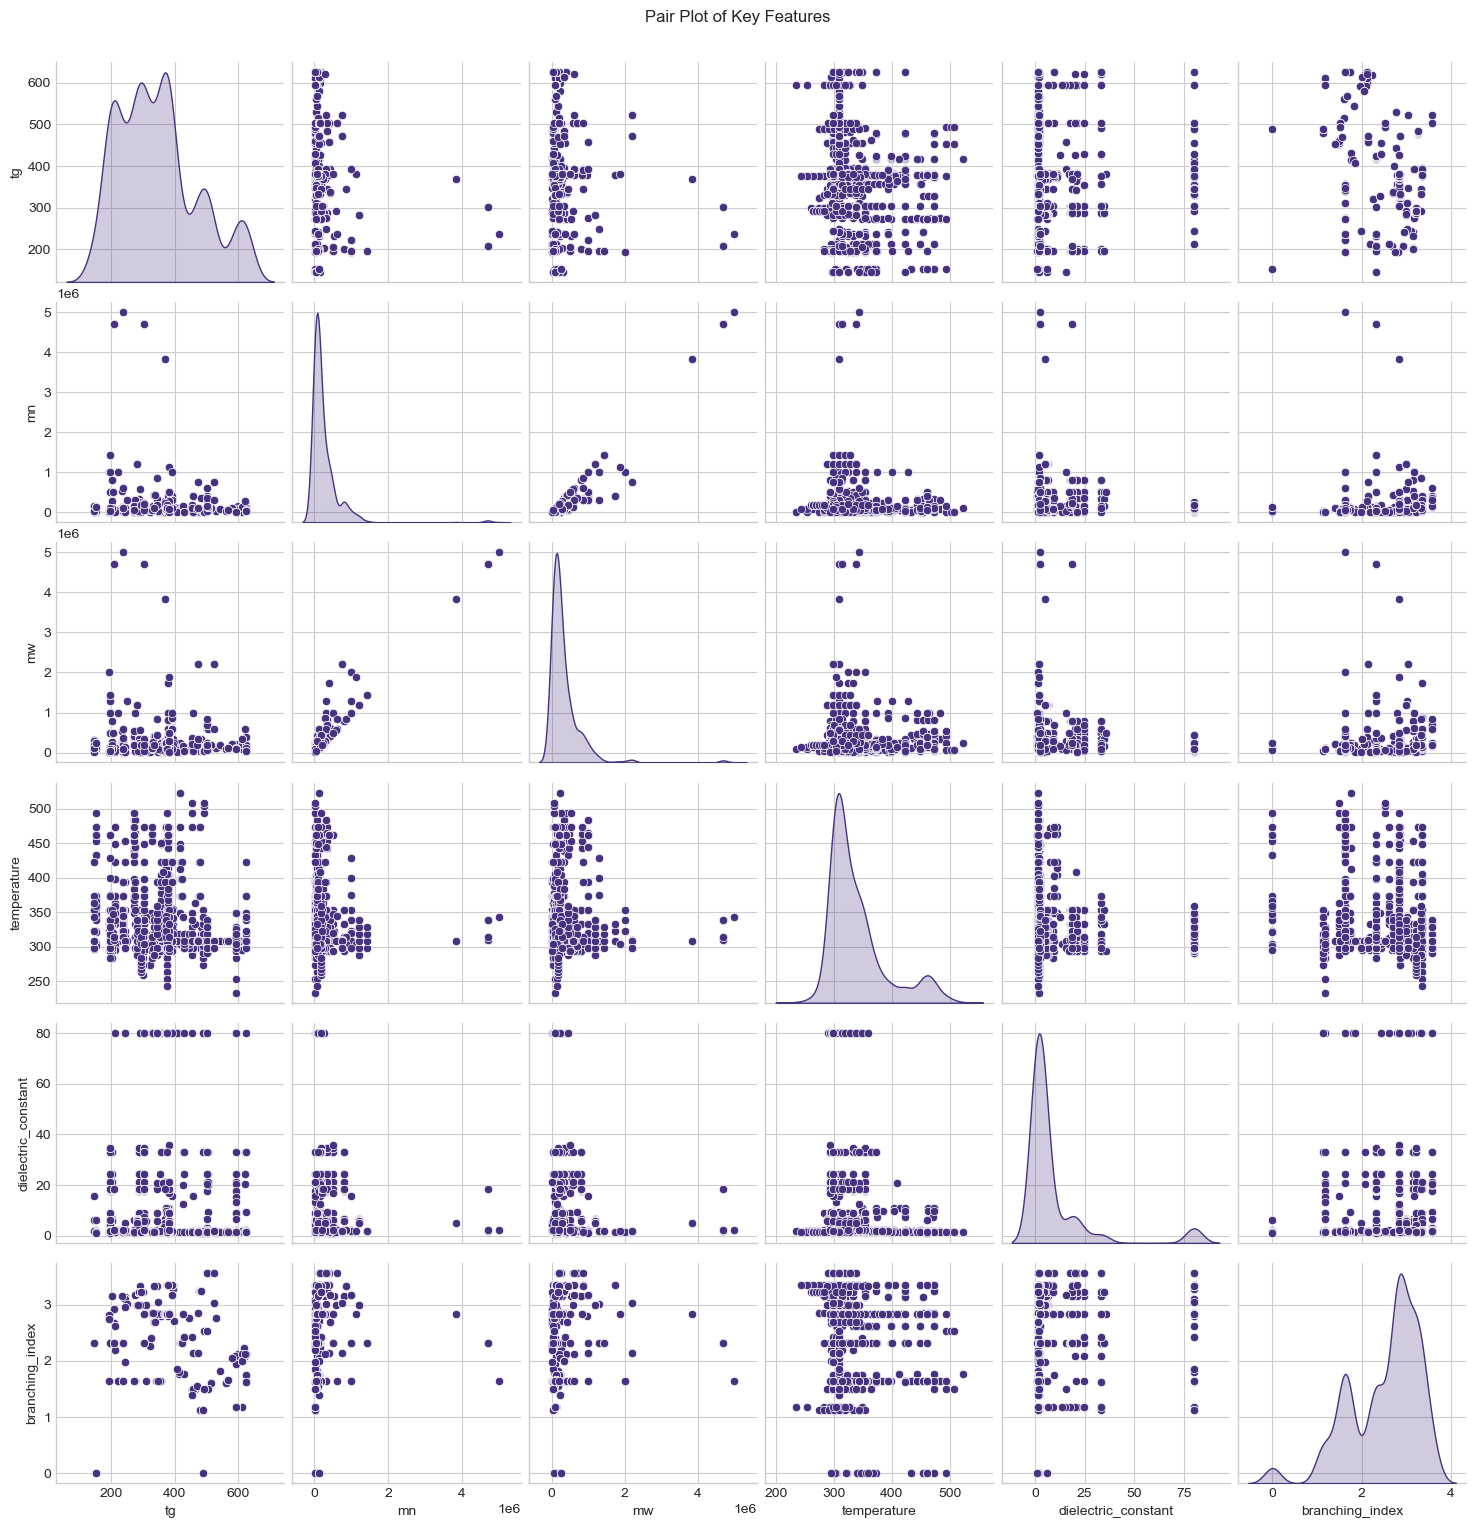

In [22]:
# Pair plot for key numerical features
# Select a subset of features to avoid overcrowding
key_features = ['tg', 'mn', 'mw', 'temperature', 'dielectric_constant', 'branching_index']
key_features = [col for col in key_features if col in df.columns]

# Create pair plot
sns.pairplot(df[key_features], diag_kind='kde')
plt.suptitle('Pair Plot of Key Features', y=1.02)
plt.show()

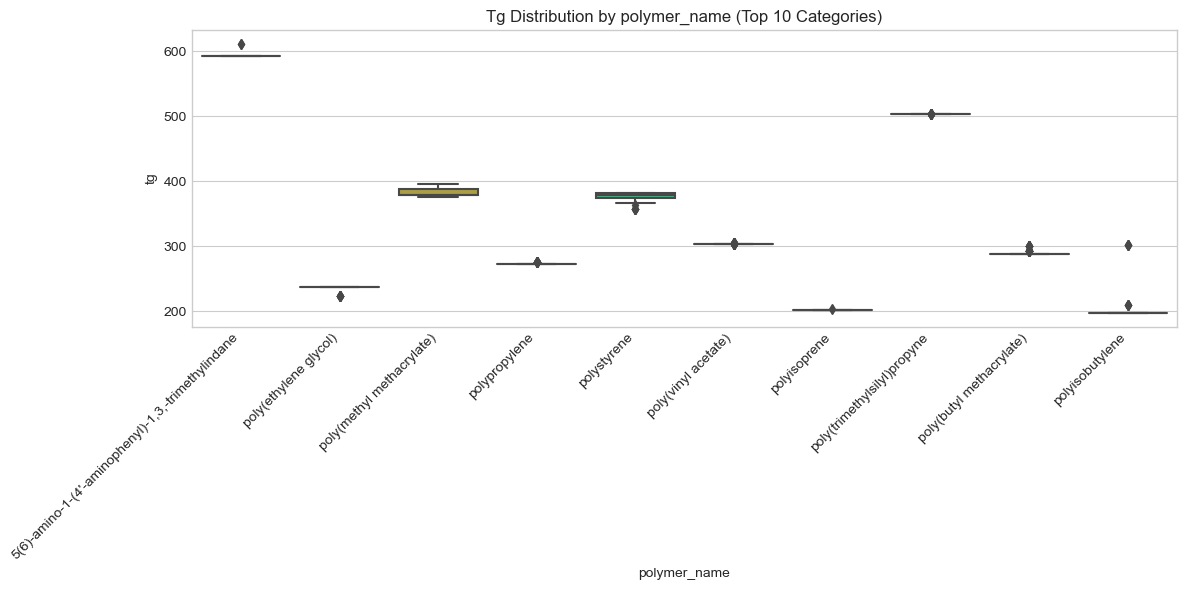

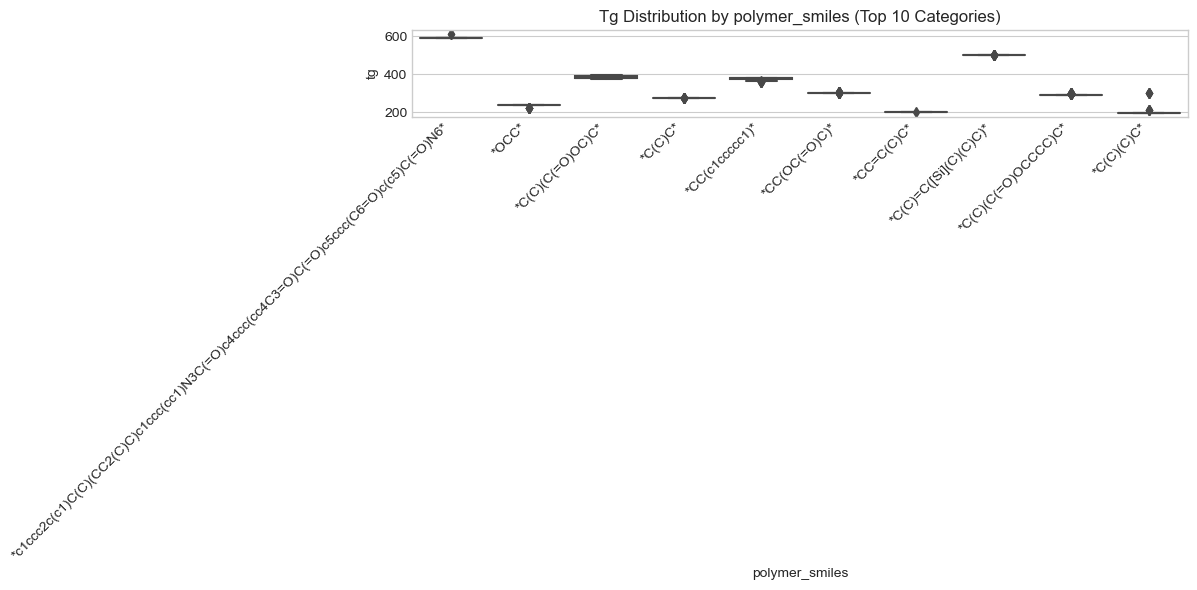

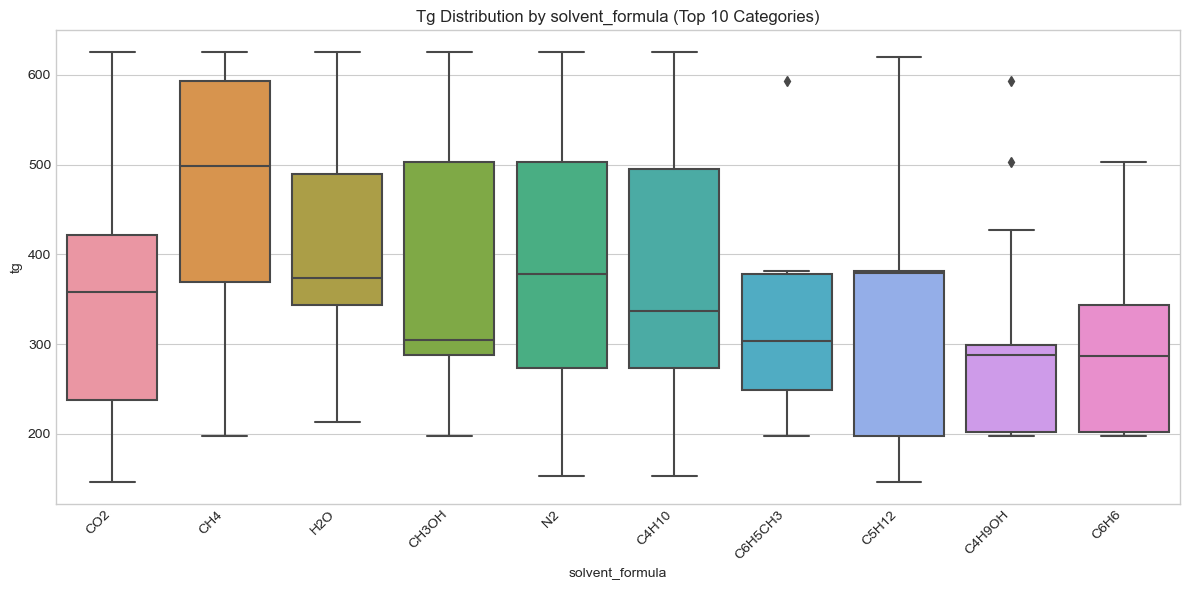

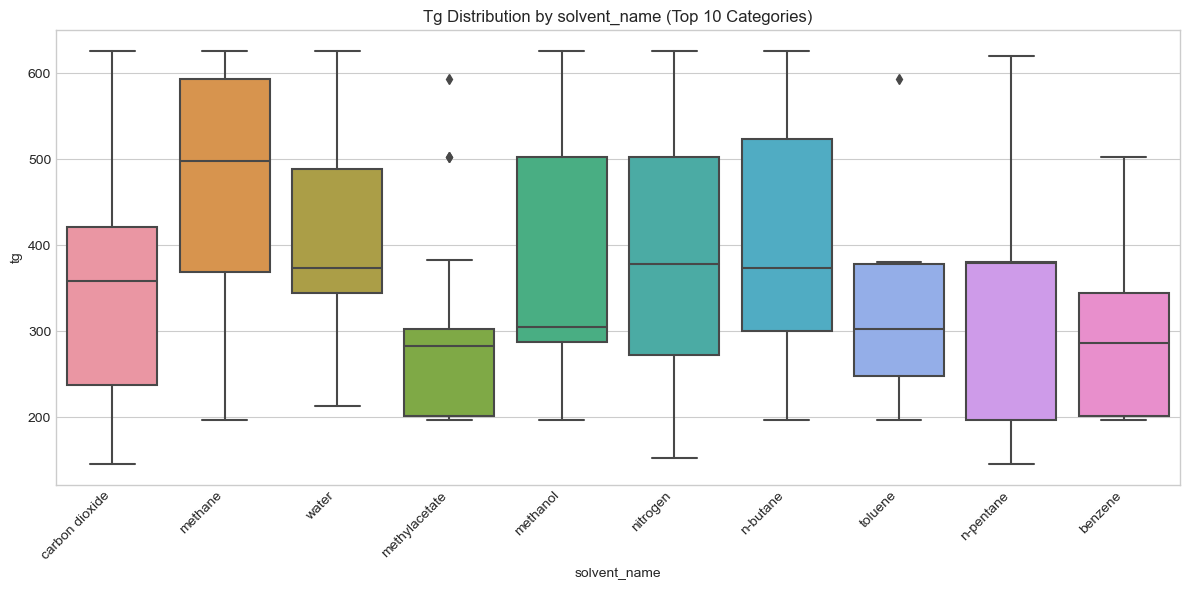

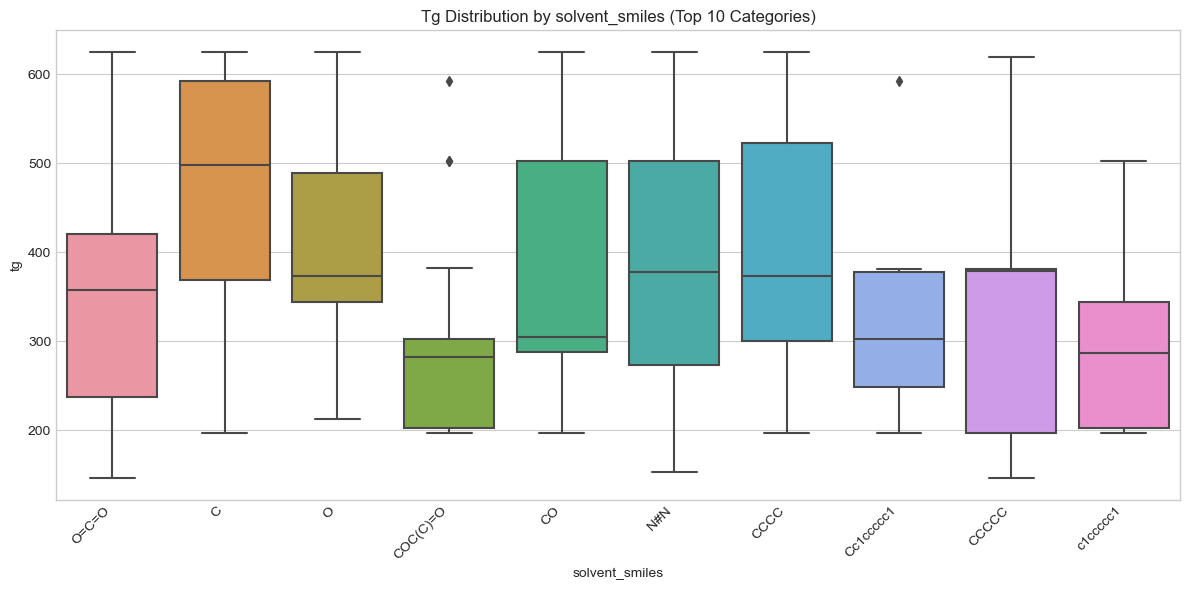

In [23]:
# Analyze the relationship between categorical features and Tg
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

if categorical_features:
    for feature in categorical_features:
        # If there are too many categories, select top 10 by frequency
        if df[feature].nunique() > 10:
            top_categories = df[feature].value_counts().nlargest(10).index
            filtered_df = df[df[feature].isin(top_categories)]
            
            plt.figure(figsize=(12, 6))
            sns.boxplot(x=feature, y='tg', data=filtered_df)
            plt.title(f'Tg Distribution by {feature} (Top 10 Categories)')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            plt.figure(figsize=(12, 6))
            sns.boxplot(x=feature, y='tg', data=df)
            plt.title(f'Tg Distribution by {feature}')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

## 5. Skewness Analysis and Transformations

Skewness of numerical features:
mn                     6.467605
mw                     5.251091
dielectric_constant    3.095301
molar_refractivity     2.027884
temperature            1.476450
tg                     0.605403
dens                   0.065224
branching_index       -0.987885
dtype: float64

Highly skewed features (|skewness| > 1): ['mn', 'mw', 'dielectric_constant', 'molar_refractivity', 'temperature']
Applied Box-Cox transformation to mn
Applied Box-Cox transformation to mw
Applied Box-Cox transformation to dielectric_constant
Applied Box-Cox transformation to molar_refractivity
Applied Box-Cox transformation to temperature


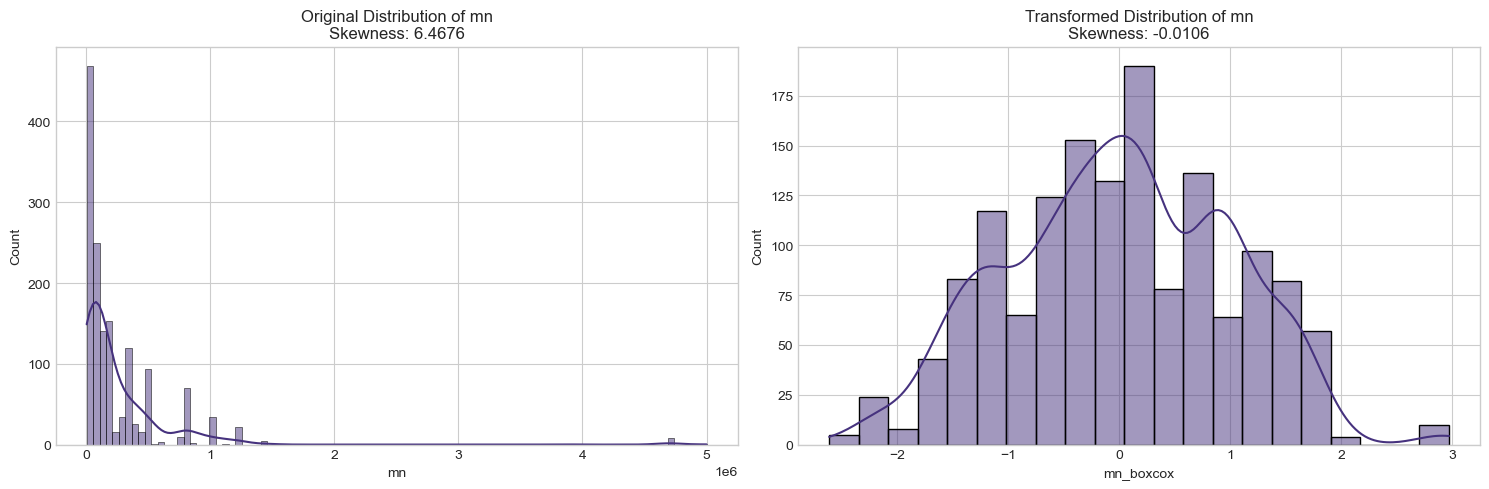

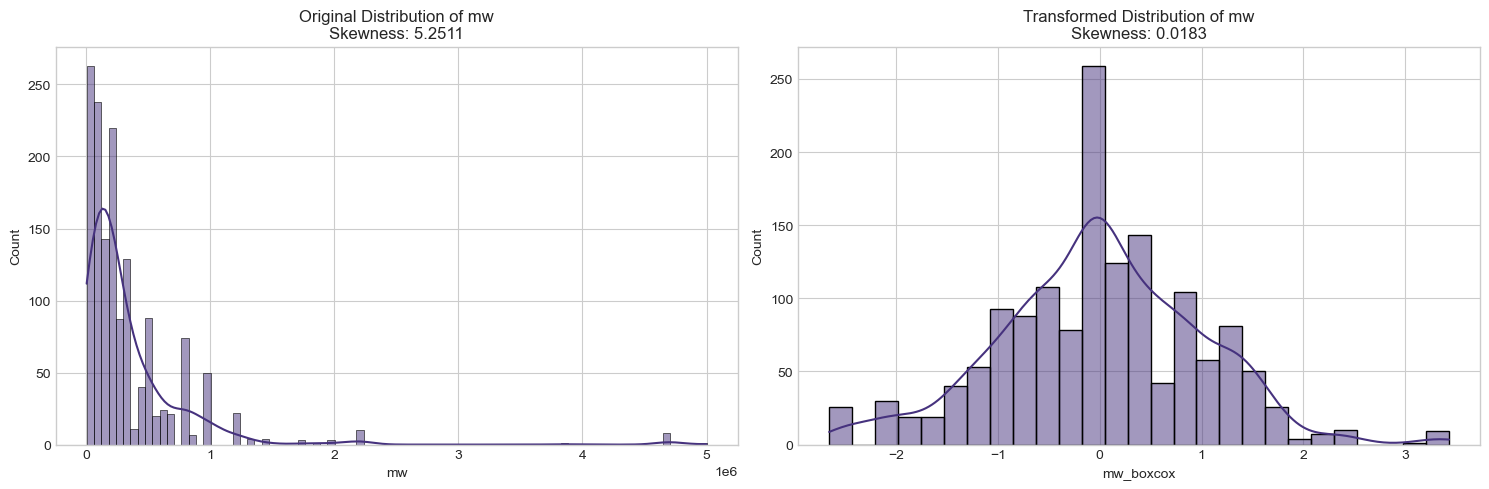

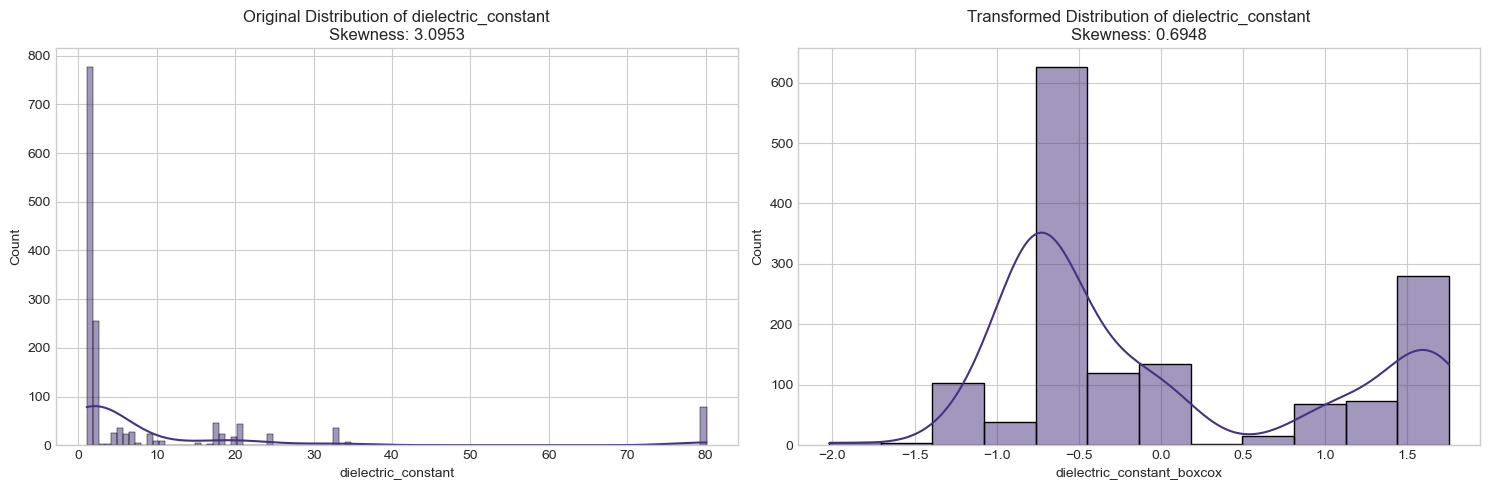

In [24]:
# Calculate skewness for numerical features
skewness = df[numerical_features].skew().sort_values(ascending=False)

print("Skewness of numerical features:")
print(skewness)

# Identify highly skewed features (|skewness| > 1)
highly_skewed = skewness[abs(skewness) > 1].index.tolist()

if highly_skewed:
    print(f"\nHighly skewed features (|skewness| > 1): {highly_skewed}")
    
    # Apply transformations to reduce skewness
    df_transformed = df.copy()
    
    # Apply Box-Cox transformation (requires positive values)
    pt = PowerTransformer(method='box-cox')
    
    for feature in highly_skewed:
        # Skip the target variable
        if feature == 'tg':
            continue
            
        # Check if all values are positive
        if (df[feature] <= 0).any():
            # Apply log transformation with offset for non-positive values
            min_val = df[feature].min()
            if min_val <= 0:
                offset = abs(min_val) + 1
                df_transformed[f"{feature}_log"] = np.log(df[feature] + offset)
                print(f"Applied log transformation to {feature} with offset {offset}")
            else:
                df_transformed[f"{feature}_log"] = np.log(df[feature])
                print(f"Applied log transformation to {feature}")
        else:
            # Apply Box-Cox transformation
            try:
                df_transformed[f"{feature}_boxcox"] = pt.fit_transform(df[[feature]])
                print(f"Applied Box-Cox transformation to {feature}")
            except Exception as e:
                print(f"Error applying Box-Cox to {feature}: {e}")
                # Fallback to log transformation
                df_transformed[f"{feature}_log"] = np.log(df[feature])
                print(f"Applied log transformation to {feature} instead")
    
    # Compare original and transformed distributions for a few features
    for feature in highly_skewed[:3]:  # Show first 3 for brevity
        if feature == 'tg':
            continue
            
        plt.figure(figsize=(15, 5))
        
        # Original distribution
        plt.subplot(1, 2, 1)
        sns.histplot(df[feature], kde=True)
        plt.title(f'Original Distribution of {feature}\nSkewness: {df[feature].skew():.4f}')
        
        # Transformed distribution
        transformed_col = next((col for col in df_transformed.columns if col.startswith(f"{feature}_")), None)
        if transformed_col:
            plt.subplot(1, 2, 2)
            sns.histplot(df_transformed[transformed_col], kde=True)
            plt.title(f'Transformed Distribution of {feature}\nSkewness: {df_transformed[transformed_col].skew():.4f}')
        
        plt.tight_layout()
        plt.show()
else:
    print("No highly skewed features found (|skewness| > 1).")

## 6. Feature Importance Analysis

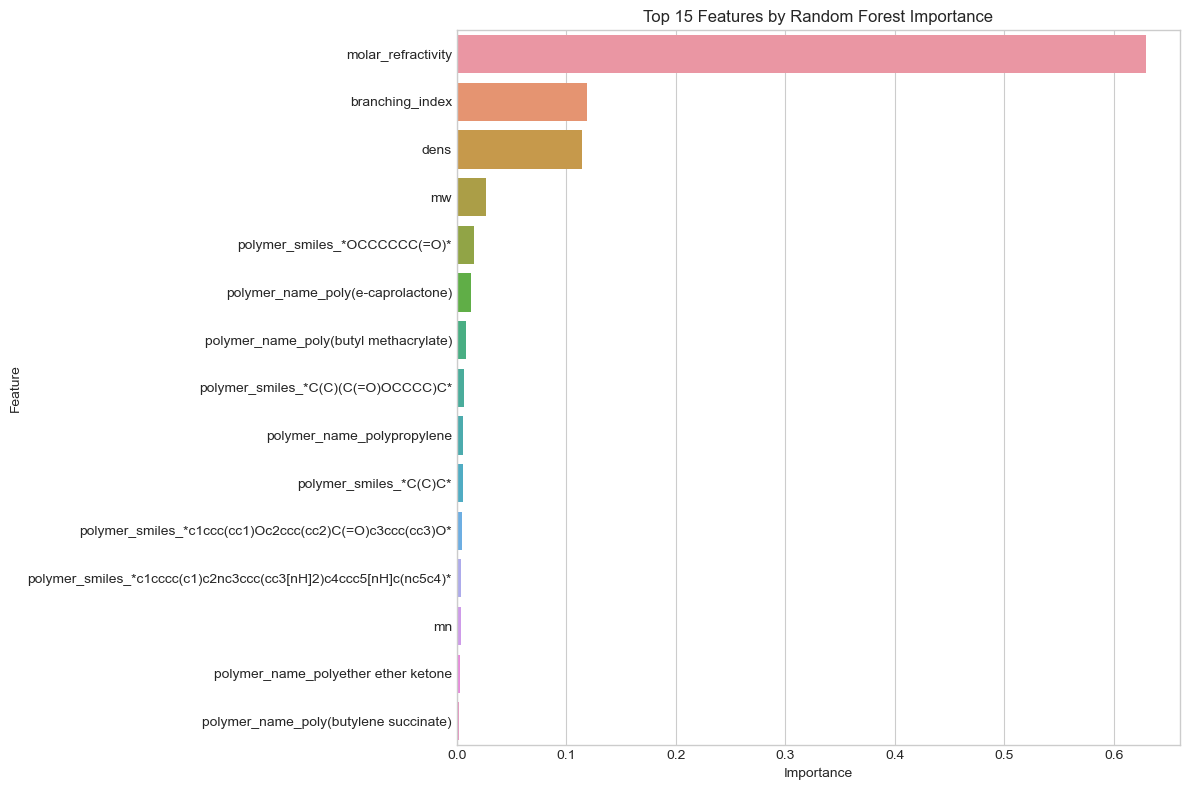

Top 15 features by Random Forest importance:
                                               Feature  Importance
6                                   molar_refractivity    0.629212
5                                      branching_index    0.119301
2                                                 dens    0.114096
1                                                   mw    0.026291
154                       polymer_smiles_*OCCCCCC(=O)*    0.015555
42                   polymer_name_poly(e-caprolactone)    0.013067
39               polymer_name_poly(butyl methacrylate)    0.007960
96                  polymer_smiles_*C(C)(C(=O)OCCCC)C*    0.006617
85                          polymer_name_polypropylene    0.006030
106                             polymer_smiles_*C(C)C*    0.005455
167  polymer_smiles_*c1ccc(cc1)Oc2ccc(cc2)C(=O)c3cc...    0.004430
170  polymer_smiles_*c1cccc(c1)c2nc3ccc(cc3[nH]2)c4...    0.004058
0                                                   mn    0.003813
79               

In [25]:
# Prepare data for feature importance analysis
# Select only numerical features for modeling
X_numerical = df.select_dtypes(include=['int64', 'float64']).drop('tg', axis=1, errors='ignore')
y = df['tg']

# Handle categorical features if needed
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
if categorical_features:
    # One-hot encode categorical features
    X_categorical = pd.get_dummies(df[categorical_features], drop_first=True)
    
    # Combine numerical and encoded categorical features
    X = pd.concat([X_numerical, X_categorical], axis=1)
else:
    X = X_numerical

# Random Forest feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Top 15 Features by Random Forest Importance')
plt.tight_layout()
plt.show()

# Display top 15 important features
print("Top 15 features by Random Forest importance:")
print(feature_importances.head(15))

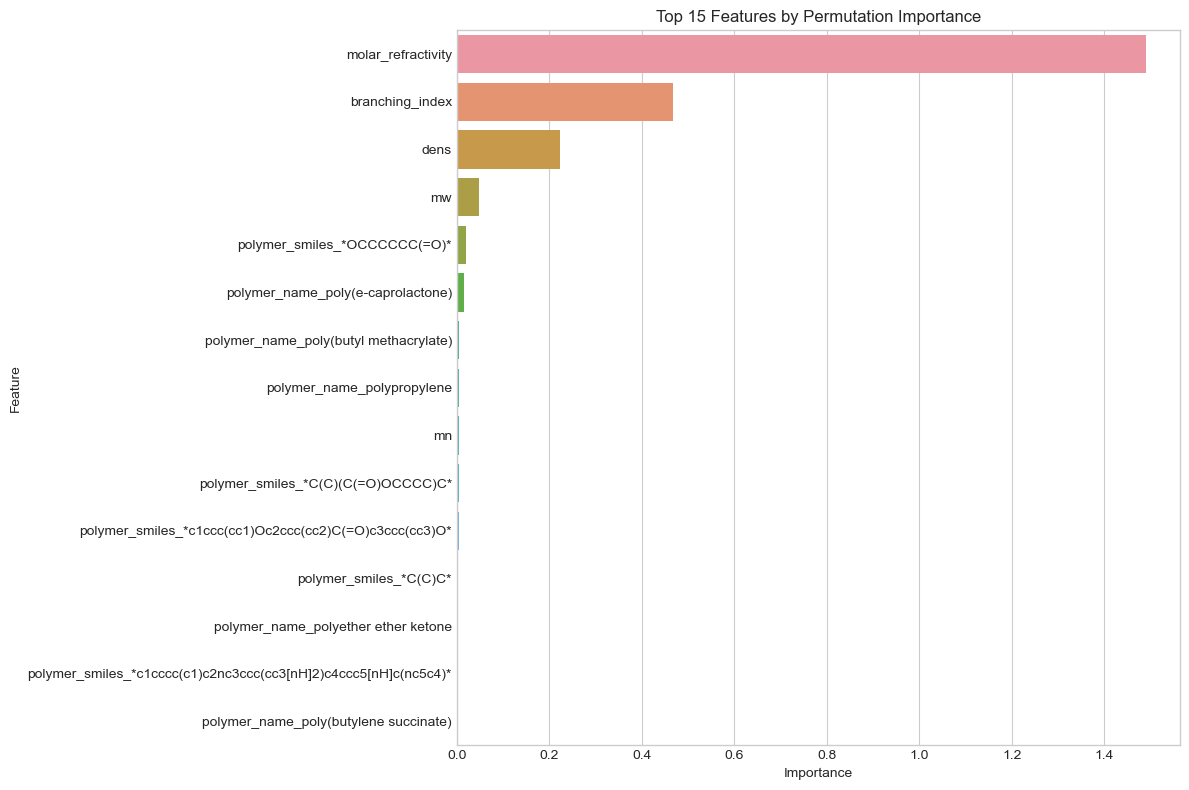

Top 15 features by Permutation importance:
                                               Feature  Importance
6                                   molar_refractivity    1.489230
5                                      branching_index    0.467475
2                                                 dens    0.223248
1                                                   mw    0.048091
154                       polymer_smiles_*OCCCCCC(=O)*    0.019311
42                   polymer_name_poly(e-caprolactone)    0.014755
39               polymer_name_poly(butyl methacrylate)    0.005162
85                          polymer_name_polypropylene    0.004753
0                                                   mn    0.004654
96                  polymer_smiles_*C(C)(C(=O)OCCCC)C*    0.004634
167  polymer_smiles_*c1ccc(cc1)Oc2ccc(cc2)C(=O)c3cc...    0.003727
106                             polymer_smiles_*C(C)C*    0.002889
79                 polymer_name_polyether ether ketone    0.002371
170  polymer_smiles

In [26]:
# Permutation importance (more reliable than feature_importances_)
perm_importance = permutation_importance(rf, X, y, n_repeats=10, random_state=42)

# Create DataFrame of permutation importances
perm_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

# Plot permutation importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importances.head(15))
plt.title('Top 15 Features by Permutation Importance')
plt.tight_layout()
plt.show()

# Display top 15 important features by permutation importance
print("Top 15 features by Permutation importance:")
print(perm_importances.head(15))

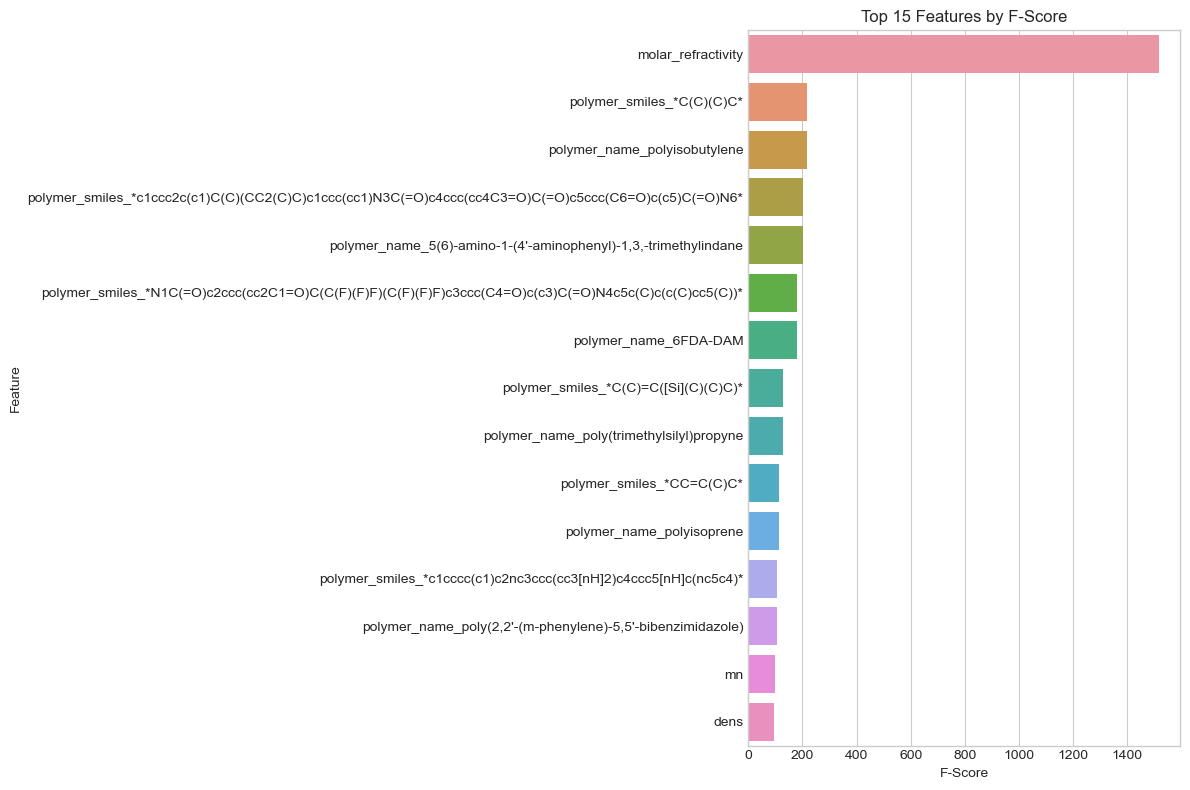

Top 15 features by F-Score:
                                               Feature      F-Score  \
6                                   molar_refractivity  1519.472989   
100                          polymer_smiles_*C(C)(C)C*   216.429528   
82                        polymer_name_polyisobutylene   216.429528   
169  polymer_smiles_*c1ccc2c(c1)C(C)(CC2(C)C)c1ccc(...   202.265594   
11   polymer_name_5(6)-amino-1-(4'-aminophenyl)-1,3...   202.265594   
150  polymer_smiles_*N1C(=O)c2ccc(cc2C1=O)C(C(F)(F)...   181.603781   
12                               polymer_name_6FDA-DAM   181.603781   
103               polymer_smiles_*C(C)=C([Si](C)(C)C)*   126.858460   
66            polymer_name_poly(trimethylsilyl)propyne   126.858460   
146                          polymer_smiles_*CC=C(C)C*   114.525608   
83                           polymer_name_polyisoprene   114.525608   
170  polymer_smiles_*c1cccc(c1)c2nc3ccc(cc3[nH]2)c4...   105.285501   
18   polymer_name_poly(2,2'-(m-phenylene)-5,5'-bi

In [27]:
# Feature selection using SelectKBest with f_regression
selector = SelectKBest(score_func=f_regression, k=10)
selector.fit(X, y)

# Get scores
f_scores = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': selector.scores_,
    'P-Value': selector.pvalues_
}).sort_values('F-Score', ascending=False)

# Plot F-scores
plt.figure(figsize=(12, 8))
sns.barplot(x='F-Score', y='Feature', data=f_scores.head(15))
plt.title('Top 15 Features by F-Score')
plt.tight_layout()
plt.show()

# Display top 15 features by F-score
print("Top 15 features by F-Score:")
print(f_scores.head(15))

## 7. Solvent-Specific Analysis

In this section, we'll focus specifically on analyzing how different solvents affect the glass transition temperature (Tg).

In [28]:
# Group data by solvent and analyze Tg statistics
solvent_tg_stats = df.groupby('solvent_name')['tg'].agg([
    'count', 'mean', 'std', 'min', 'max',
    lambda x: x.max() - x.min()  # Range
]).rename(columns={'<lambda_0>': 'range'}).sort_values('mean', ascending=False)

# Calculate coefficient of variation (CV) for each solvent
solvent_tg_stats['cv'] = solvent_tg_stats['std'] / solvent_tg_stats['mean'] * 100

# Display solvent statistics
print("Solvent Effects on Glass Transition Temperature (Tg):")
solvent_tg_stats

Solvent Effects on Glass Transition Temperature (Tg):


count     mean         std     min    max   range  \
solvent_name                                                             
1`3-butadiene            1  625.500         NaN  625.50  625.5    0.00   
1-hexanol                1  593.000         NaN  593.00  593.0    0.00   
sulfur hexafluoride      2  593.000    0.000000  593.00  593.0    0.00   
1-pentanol               1  593.000         NaN  593.00  593.0    0.00   
hydrogen sulfide         2  564.325   86.514515  503.15  625.5  122.35   
...                    ...      ...         ...     ...    ...     ...   
isopentane               5  224.720   88.343262  153.00  379.0  226.00   
R22                      5  219.800  105.084252  146.00  381.0  235.00   
neopentane               3  197.200    0.000000  197.20  197.2    0.00   
1-butene                 5  153.000    0.000000  153.00  153.0    0.00   
1-hexene                 2  153.000    0.000000  153.00  153.0    0.00   

                            cv  
solvent_name                    
1`3-butadiene              NaN  
1-hexanol                  NaN  
sulfur hexafluoride   0.000000  
1-pentanol                 NaN  
hydrogen sulfide     15.330619  
...                        ...  
isopentane           39.312594  
R22                  47.809032  
neopentane            0.000000  
1-butene              0.000000  
1-hexene              0.000000  

[80 rows x 7 columns]

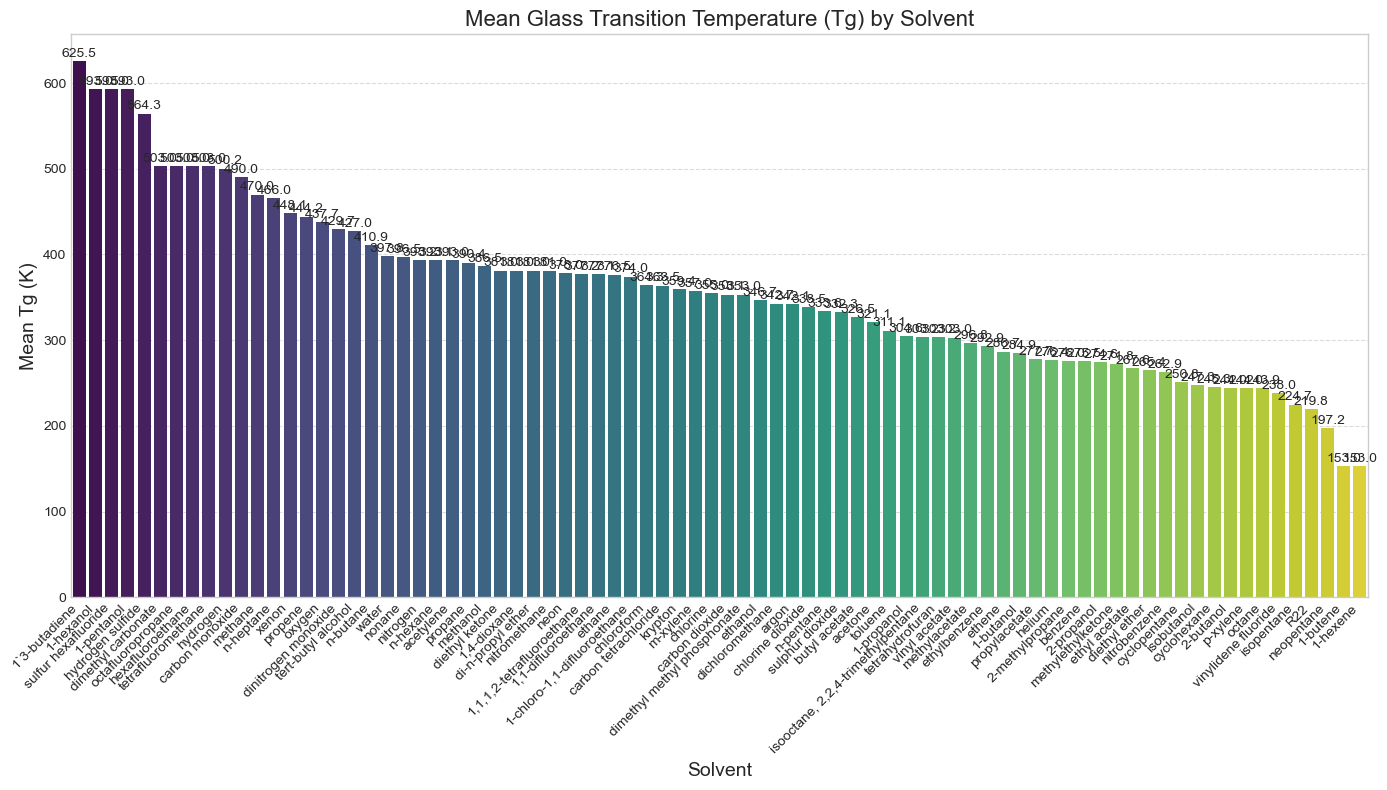

In [29]:
# Visualize mean Tg by solvent
plt.figure(figsize=(14, 8))
sns.barplot(x=solvent_tg_stats.index, y=solvent_tg_stats['mean'], palette='viridis')
plt.title('Mean Glass Transition Temperature (Tg) by Solvent', fontsize=16)
plt.xlabel('Solvent', fontsize=14)
plt.ylabel('Mean Tg (K)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for i, v in enumerate(solvent_tg_stats['mean']):
    plt.text(i, v + 5, f"{v:.1f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

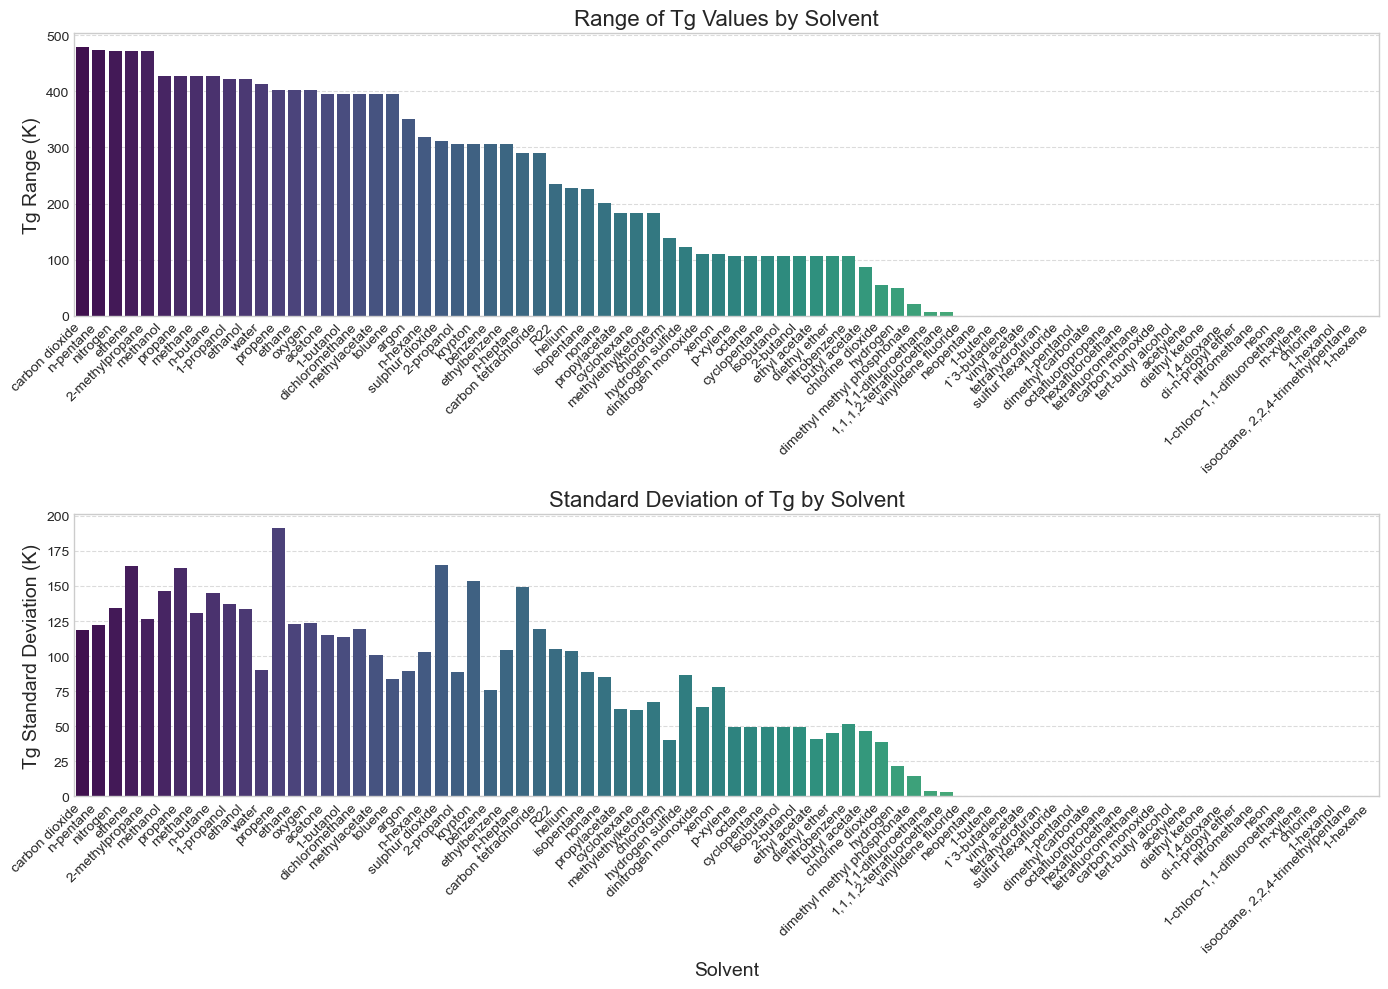

In [30]:
# Visualize Tg range and standard deviation by solvent
plt.figure(figsize=(14, 10))

# Sort by range for this visualization
sorted_by_range = solvent_tg_stats.sort_values('range', ascending=False)

# Plot range
plt.subplot(2, 1, 1)
sns.barplot(x=sorted_by_range.index, y=sorted_by_range['range'], palette='viridis')
plt.title('Range of Tg Values by Solvent', fontsize=16)
plt.xlabel('')
plt.ylabel('Tg Range (K)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot standard deviation
plt.subplot(2, 1, 2)
sns.barplot(x=sorted_by_range.index, y=sorted_by_range['std'], palette='viridis')
plt.title('Standard Deviation of Tg by Solvent', fontsize=16)
plt.xlabel('Solvent', fontsize=14)
plt.ylabel('Tg Standard Deviation (K)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

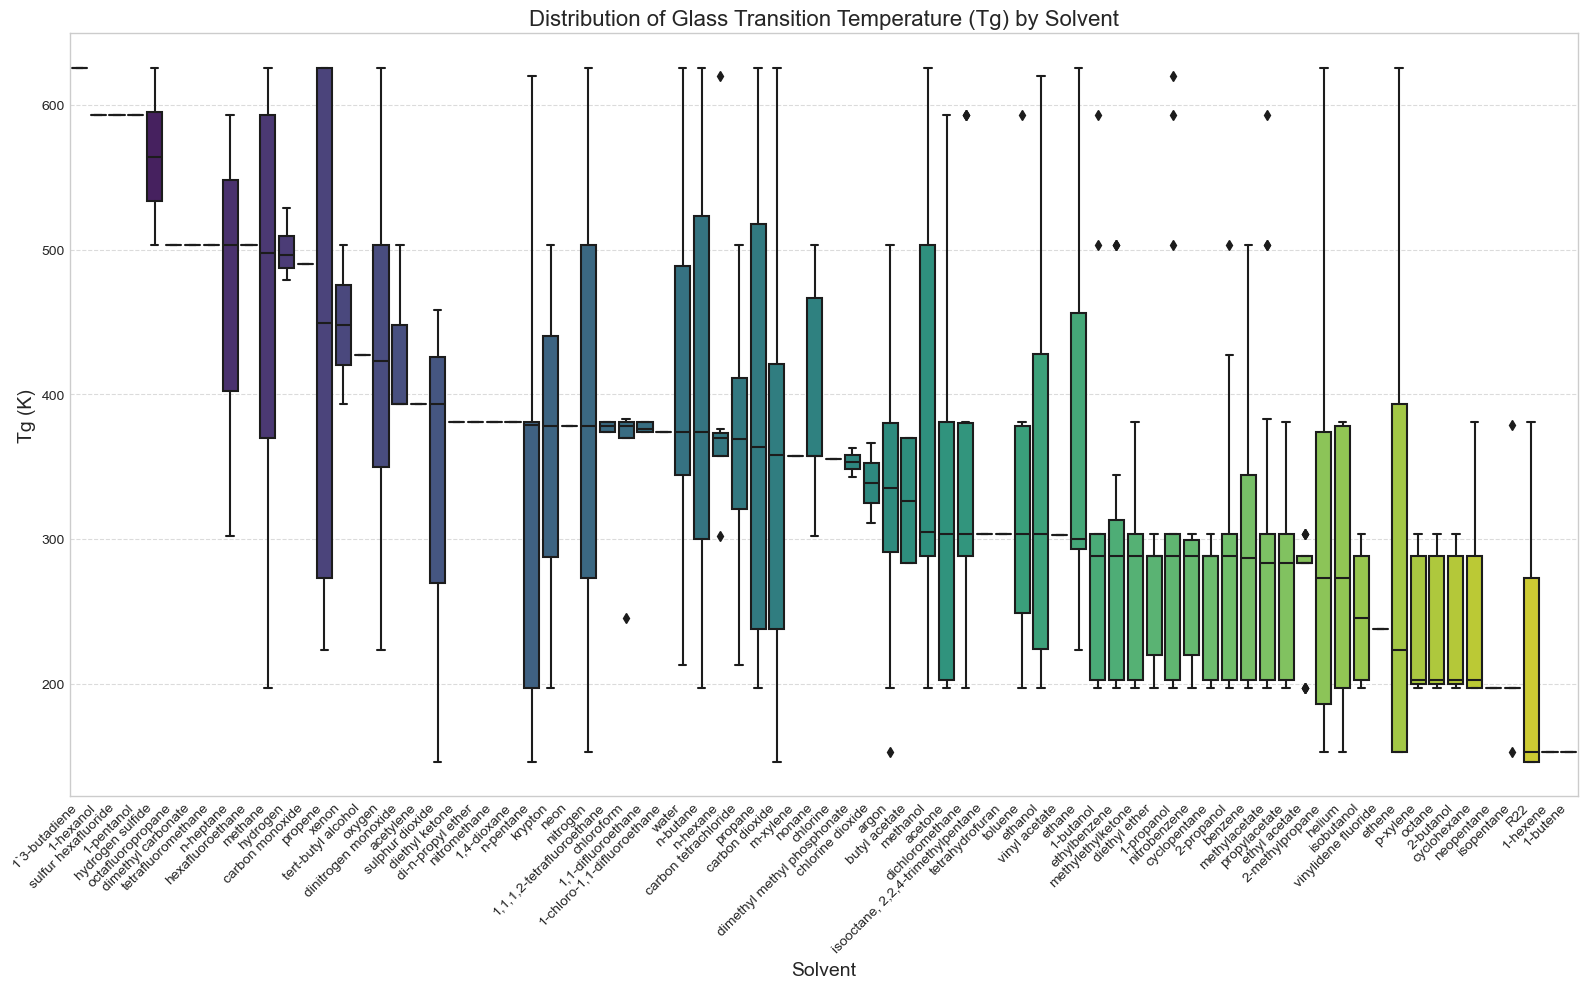

In [31]:
# Create box plots to visualize Tg distribution by solvent
plt.figure(figsize=(16, 10))

# Sort solvents by median Tg
solvent_order = df.groupby('solvent_name')['tg'].median().sort_values(ascending=False).index

# Create box plot
sns.boxplot(x='solvent_name', y='tg', data=df, order=solvent_order, palette='viridis')
plt.title('Distribution of Glass Transition Temperature (Tg) by Solvent', fontsize=16)
plt.xlabel('Solvent', fontsize=14)
plt.ylabel('Tg (K)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

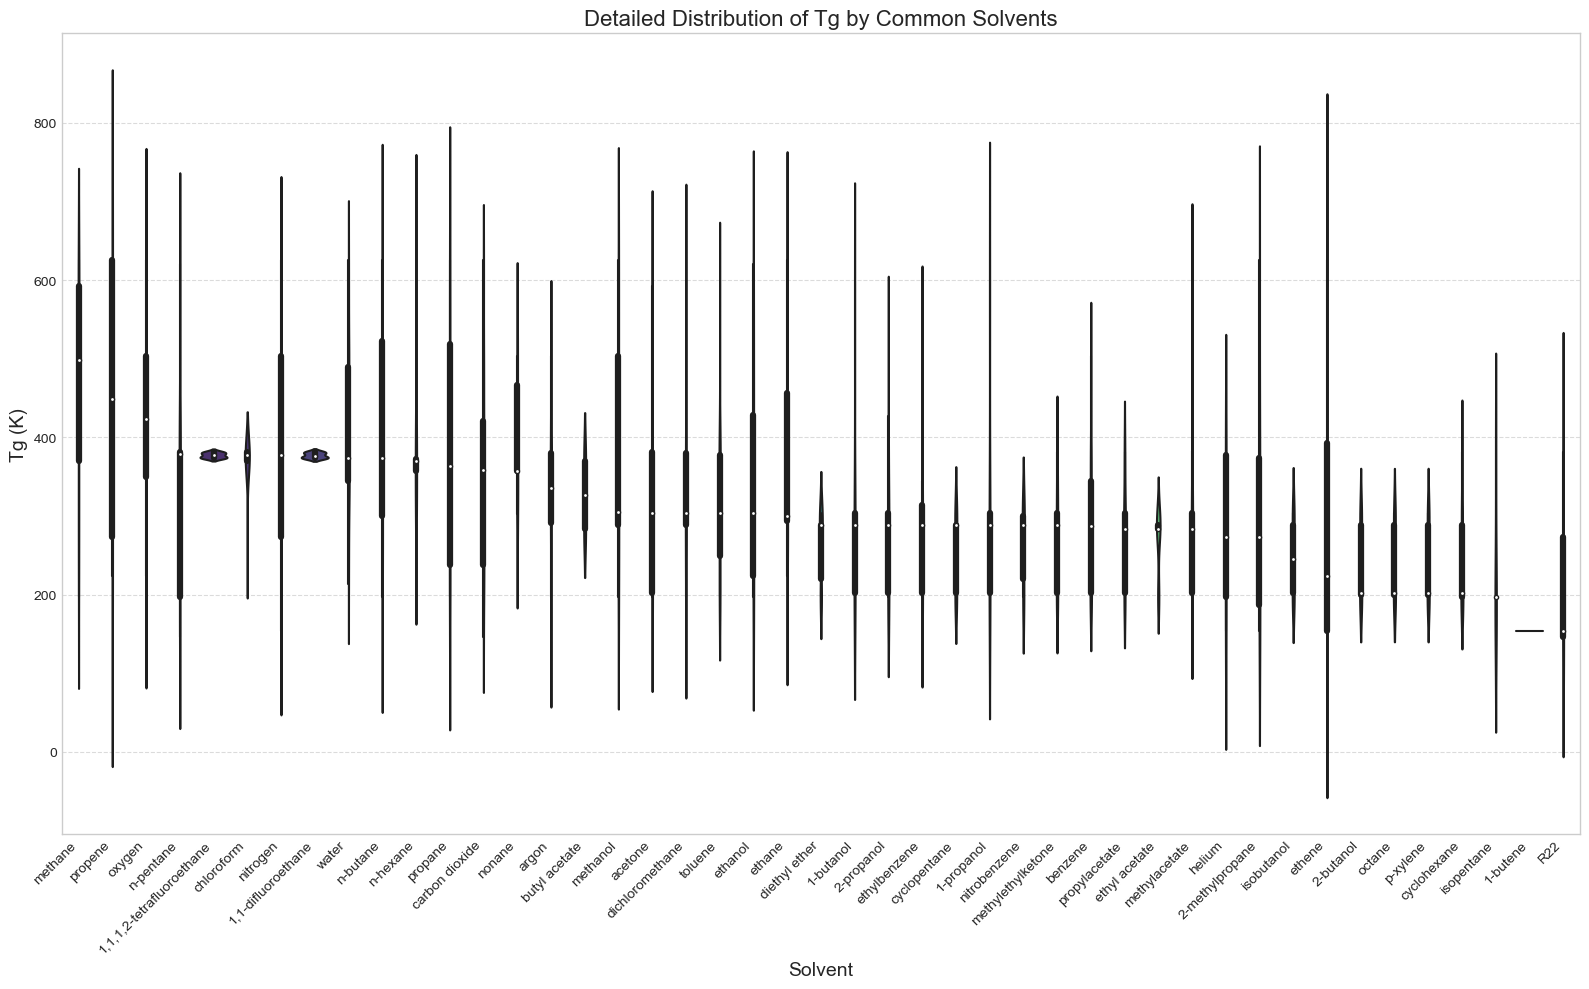

In [32]:
# Create violin plots for more detailed distribution visualization
plt.figure(figsize=(16, 10))

# Filter to include only solvents with sufficient data points
solvent_counts = df['solvent_name'].value_counts()
common_solvents = solvent_counts[solvent_counts >= 5].index.tolist()

if common_solvents:
    # Filter data for common solvents
    common_solvent_data = df[df['solvent_name'].isin(common_solvents)]
    
    # Sort by median Tg
    solvent_order = common_solvent_data.groupby('solvent_name')['tg'].median().sort_values(ascending=False).index
    
    # Create violin plot
    sns.violinplot(x='solvent_name', y='tg', data=common_solvent_data, order=solvent_order, palette='viridis', inner='box')
    plt.title('Detailed Distribution of Tg by Common Solvents', fontsize=16)
    plt.xlabel('Solvent', fontsize=14)
    plt.ylabel('Tg (K)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
else:
    plt.text(0.5, 0.5, "Insufficient data for violin plots\n(requires at least 5 data points per solvent)", 
             ha='center', va='center', fontsize=14)

plt.tight_layout()
plt.show()

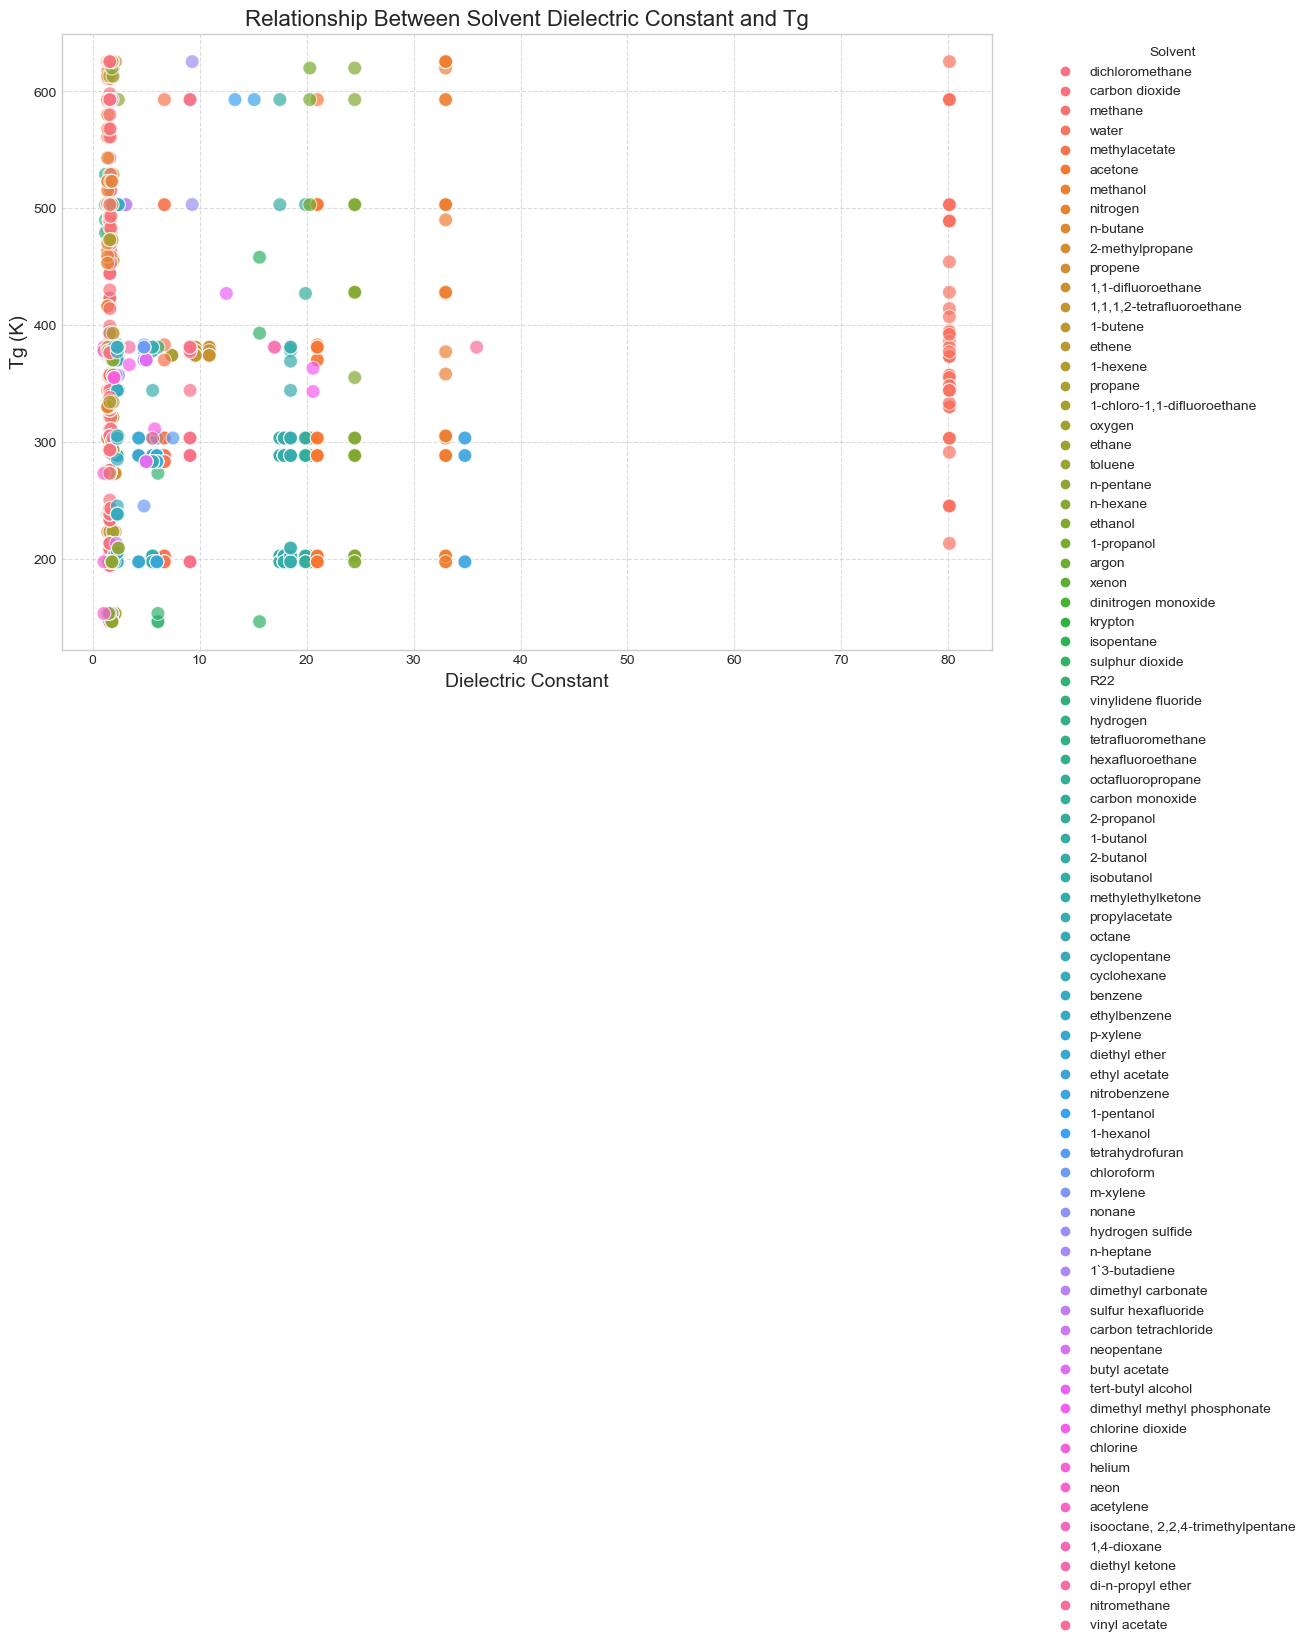

In [33]:
# Analyze relationship between solvent dielectric constant and Tg
plt.figure(figsize=(12, 8))

# Create scatter plot
sns.scatterplot(x='dielectric_constant', y='tg', hue='solvent_name', data=df, s=100, alpha=0.7)
plt.title('Relationship Between Solvent Dielectric Constant and Tg', fontsize=16)
plt.xlabel('Dielectric Constant', fontsize=14)
plt.ylabel('Tg (K)', fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title='Solvent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

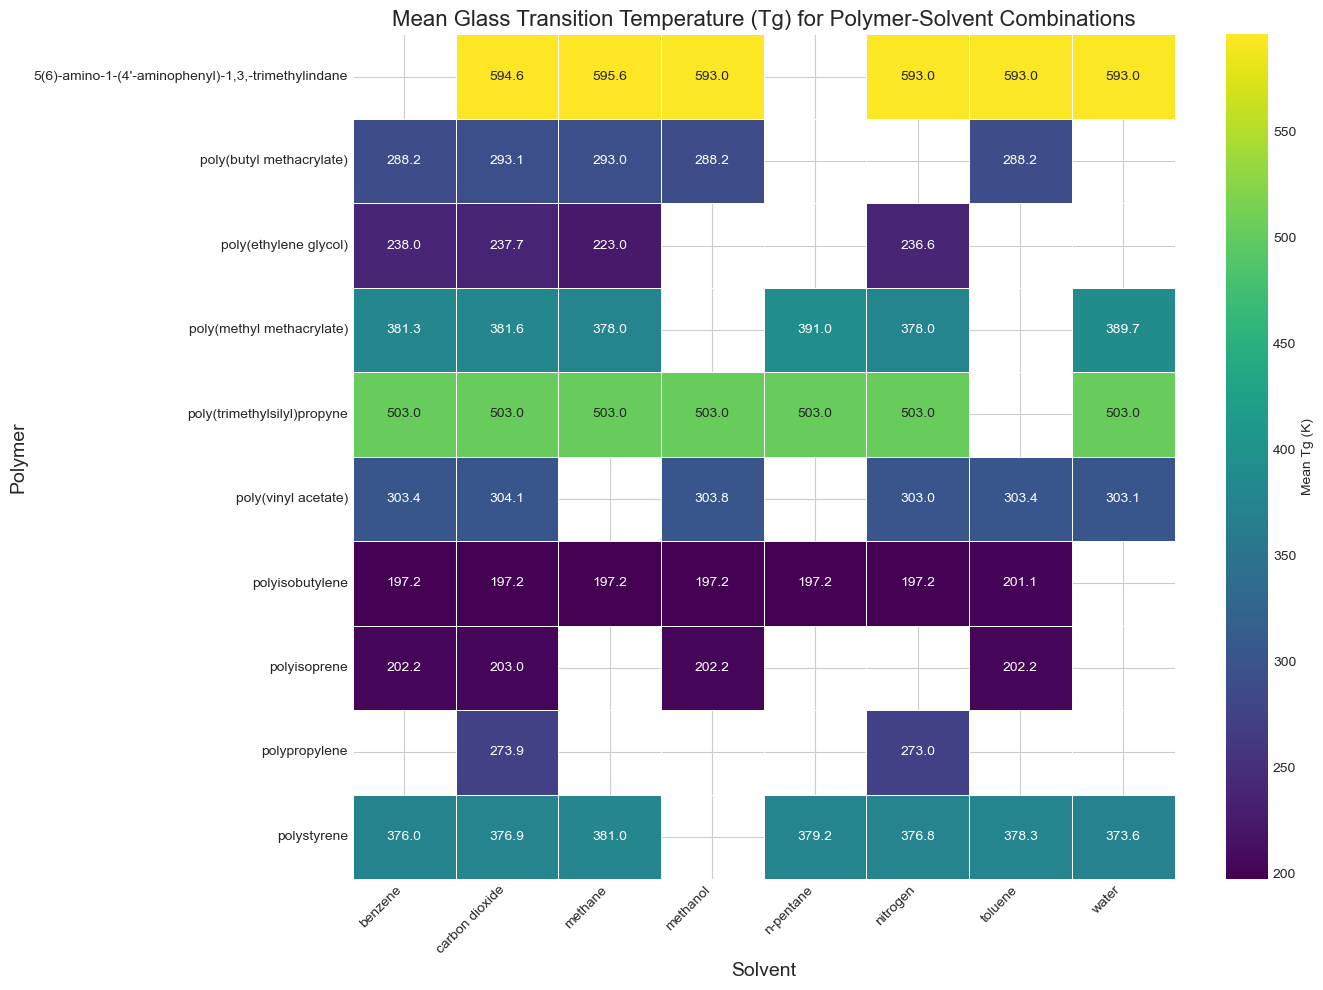

In [34]:
# Create a heatmap showing average Tg for polymer-solvent combinations
# First, identify the top polymers and solvents by frequency
top_polymers = df['polymer_name'].value_counts().nlargest(10).index
top_solvents = df['solvent_name'].value_counts().nlargest(8).index

# Filter data for top polymers and solvents
filtered_df = df[df['polymer_name'].isin(top_polymers) & df['solvent_name'].isin(top_solvents)]

# Create pivot table
pivot_table = filtered_df.pivot_table(values='tg', index='polymer_name', columns='solvent_name', aggfunc='mean')

# Create heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='viridis', linewidths=0.5, cbar_kws={'label': 'Mean Tg (K)'})
plt.title('Mean Glass Transition Temperature (Tg) for Polymer-Solvent Combinations', fontsize=16)
plt.xlabel('Solvent', fontsize=14)
plt.ylabel('Polymer', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

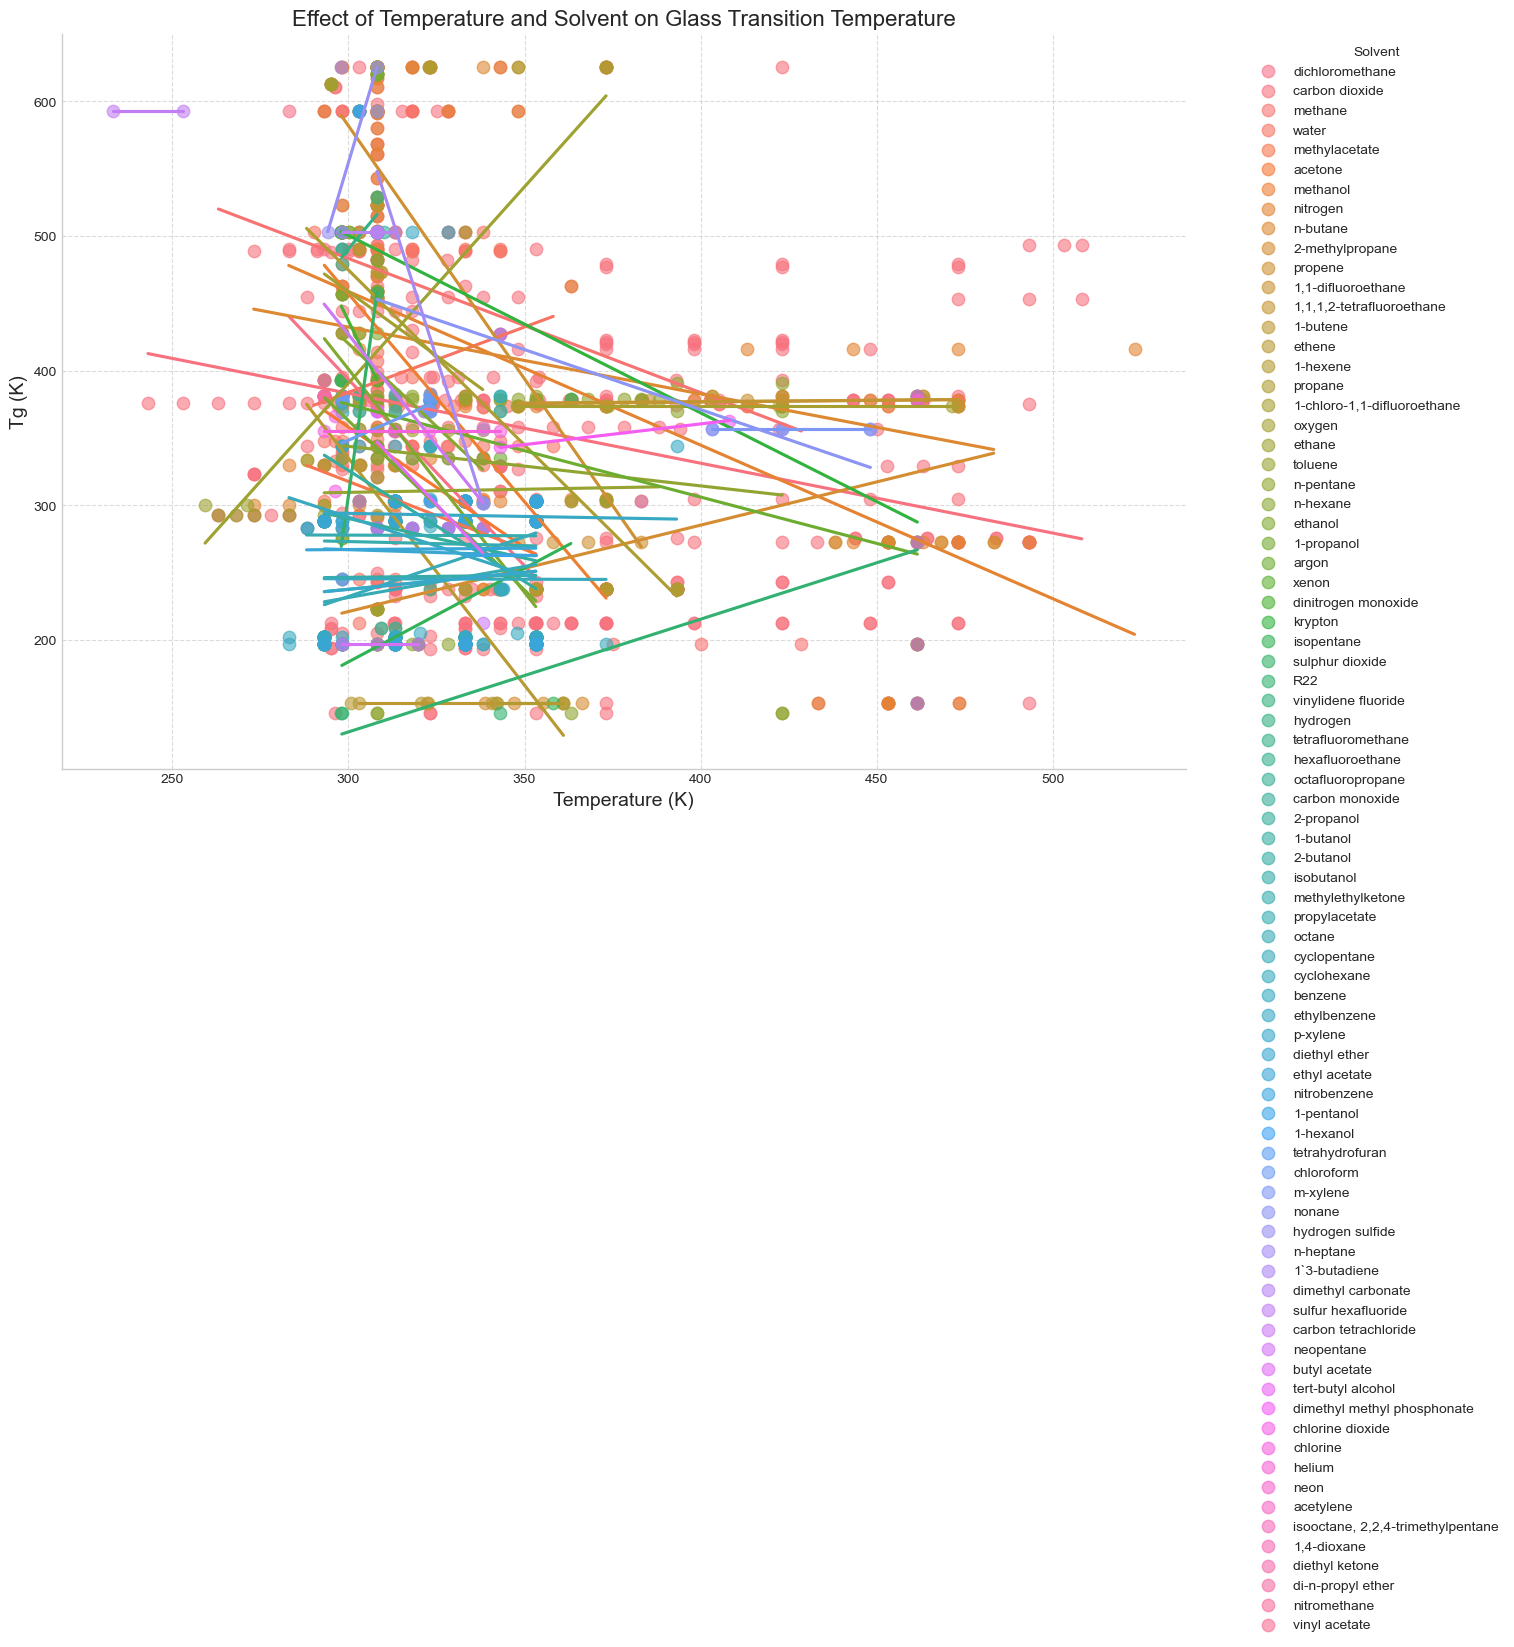

In [35]:
# Analyze the effect of temperature and solvent on Tg
plt.figure(figsize=(14, 8))

# Create scatter plot with regression lines for each solvent
sns.lmplot(x='temperature', y='tg', hue='solvent_name', data=df, height=8, aspect=1.5, 
           scatter_kws={'alpha': 0.6, 's': 80}, ci=None, legend=False)

plt.title('Effect of Temperature and Solvent on Glass Transition Temperature', fontsize=16)
plt.xlabel('Temperature (K)', fontsize=14)
plt.ylabel('Tg (K)', fontsize=14)
plt.grid(linestyle='--', alpha=0.7)
plt.legend(title='Solvent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

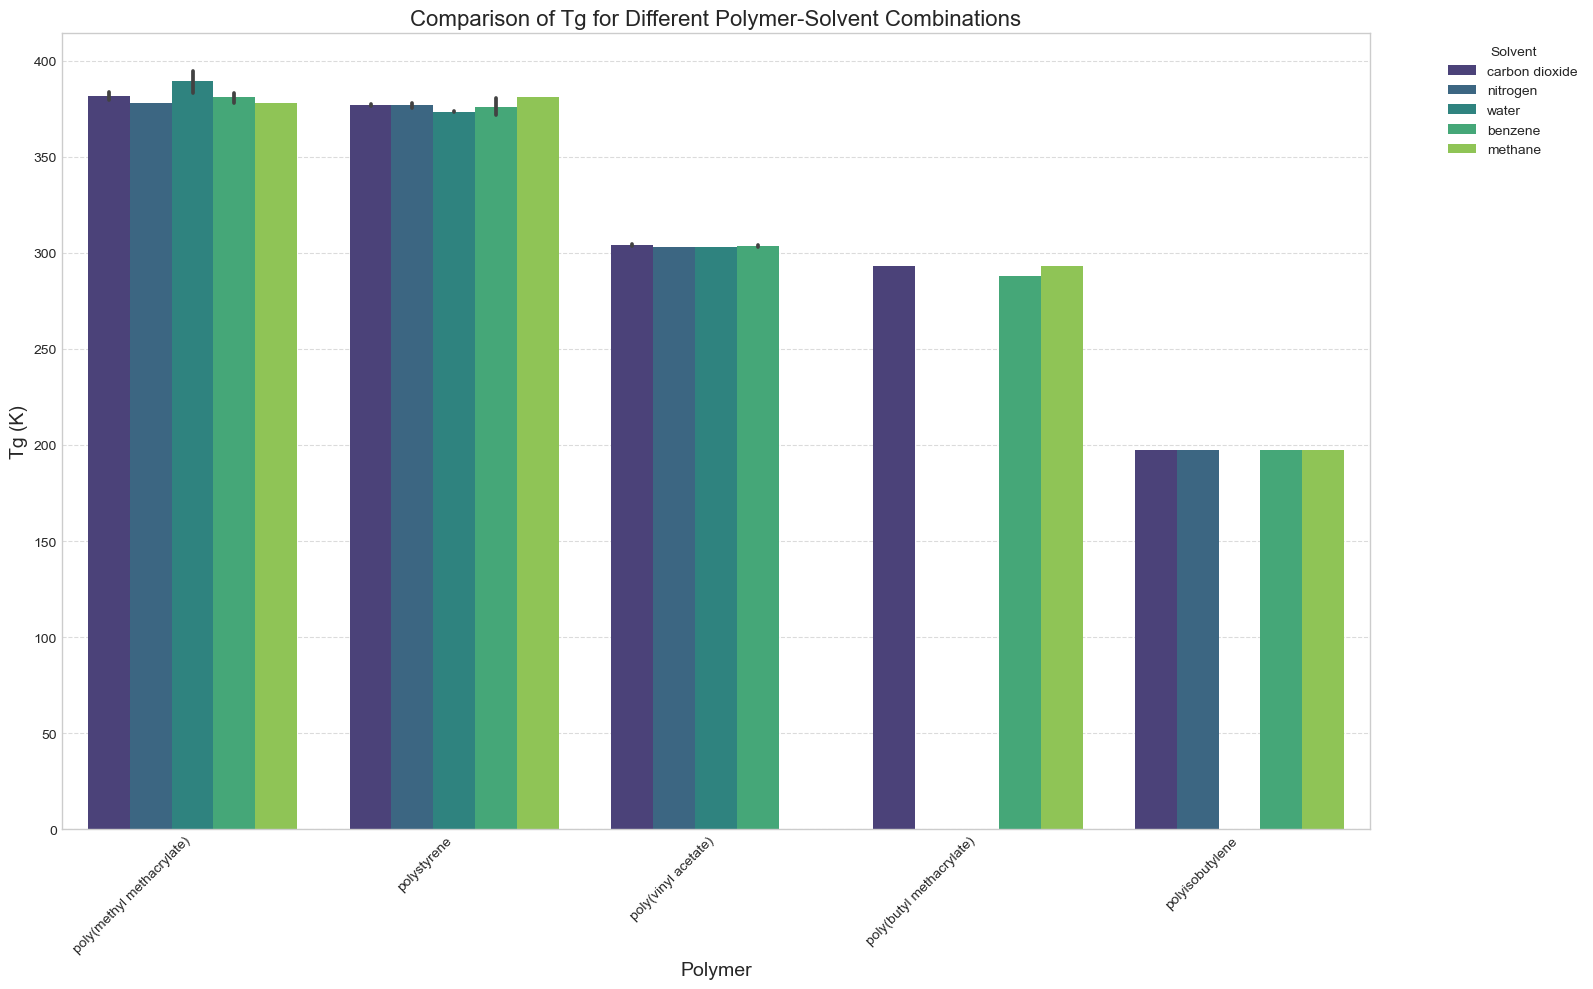

In [36]:
# Create a grouped bar chart comparing Tg for different polymer-solvent combinations
# Select a few common polymers for comparison
common_polymers = df['polymer_name'].value_counts().nlargest(5).index
common_solvents = df['solvent_name'].value_counts().nlargest(5).index

# Filter data
comparison_df = df[df['polymer_name'].isin(common_polymers) & df['solvent_name'].isin(common_solvents)]

# Create grouped bar chart
plt.figure(figsize=(16, 10))
sns.barplot(x='polymer_name', y='tg', hue='solvent_name', data=comparison_df, palette='viridis')
plt.title('Comparison of Tg for Different Polymer-Solvent Combinations', fontsize=16)
plt.xlabel('Polymer', fontsize=14)
plt.ylabel('Tg (K)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Solvent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

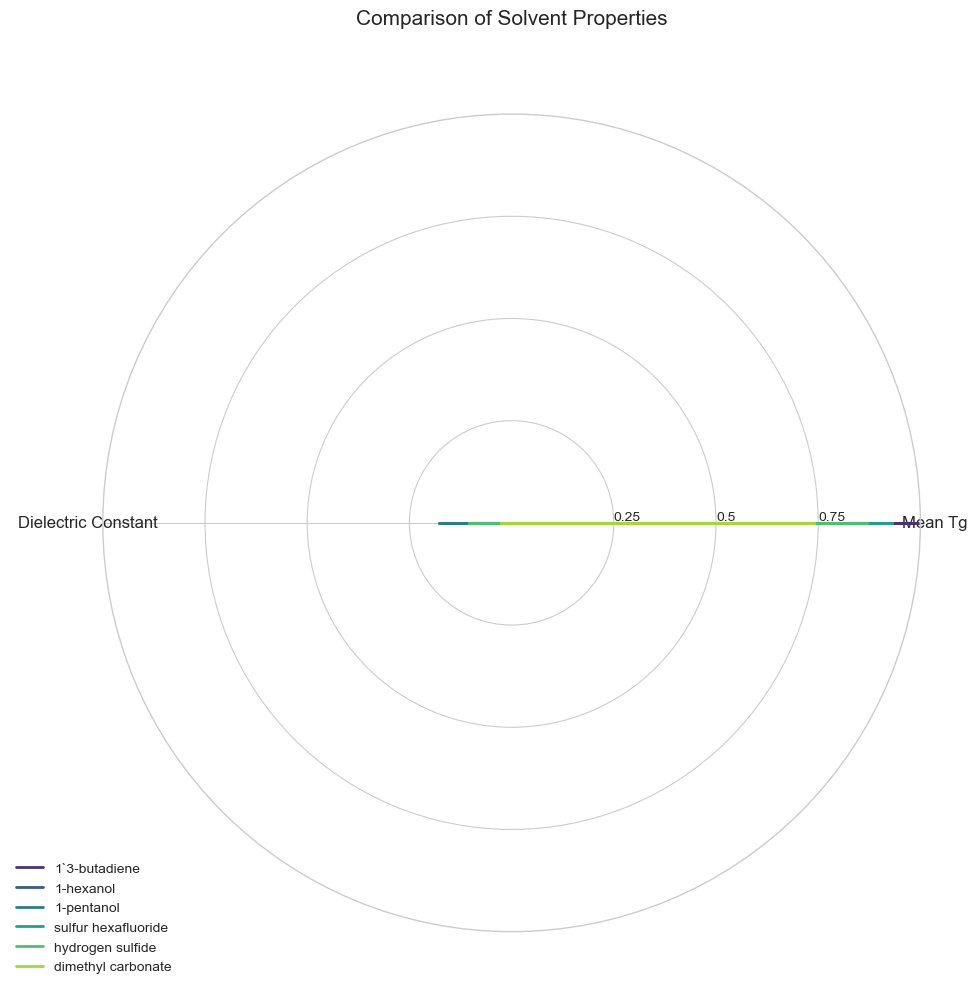

In [ ]:

    iqr_outliers, lower, upper = detect_outliers_iqr(df, col)
    iqr_count = len(iqr_outliers)caler
scaler = MinMaxScaler()
solvent_metrics[['tg_norm', 'dielectric_constant_norm']] = scaler.fit_transform(solvent_metrics[['tg', 'dielectric_constant']])

# Select top solvents for clarity
top_solvents_radar = solvent_metrics.nlargest(6, 'tg')

# Create radar chart
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# Function to create radar chart
def radar_chart(categories, values, title):
    # Number of variables
    N = len(categories)
    
    # What will be the angle of each axis in the plot
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], categories, size=12)
    
    # Draw the y-axis labels (0-100)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ['0.25', '0.5', '0.75'], size=10)
    plt.ylim(0, 1)
    
    # Plot each solvent
    for i, solvent in enumerate(values.index):
        values_solvent = values.loc[solvent].values.tolist()
        values_solvent += values_solvent[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, values_solvent, linewidth=2, linestyle='solid', label=solvent)
        ax.fill(angles, values_solvent, alpha=0.1)
    
    # Add title and legend
    plt.title(title, size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    return fig, ax

# Prepare data for radar chart
radar_data = top_solvents_radar.set_index('solvent_name')[['tg_norm', 'dielectric_constant_norm']]

# Create radar chart
try:
    radar_chart(['Mean Tg', 'Dielectric Constant'], radar_data, 'Comparison of Solvent Properties')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error creating radar chart: {e}")
    print("Creating alternative visualization instead...")
    
    # Alternative visualization
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='tg', y='dielectric_constant', data=solvent_metrics, s=100)
    
    # Add labels for each point
    for i, row in solvent_metrics.iterrows():
        plt.text(row['tg'], row['dielectric_constant'], row['solvent_name'], 
                 fontsize=10, ha='center', va='bottom')
    
    plt.title('Relationship Between Mean Tg and Dielectric Constant by Solvent', fontsize=16)
    plt.xlabel('Mean Tg (K)', fontsize=14)
    plt.ylabel('Mean Dielectric Constant', fontsize=14)
    plt.grid(linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

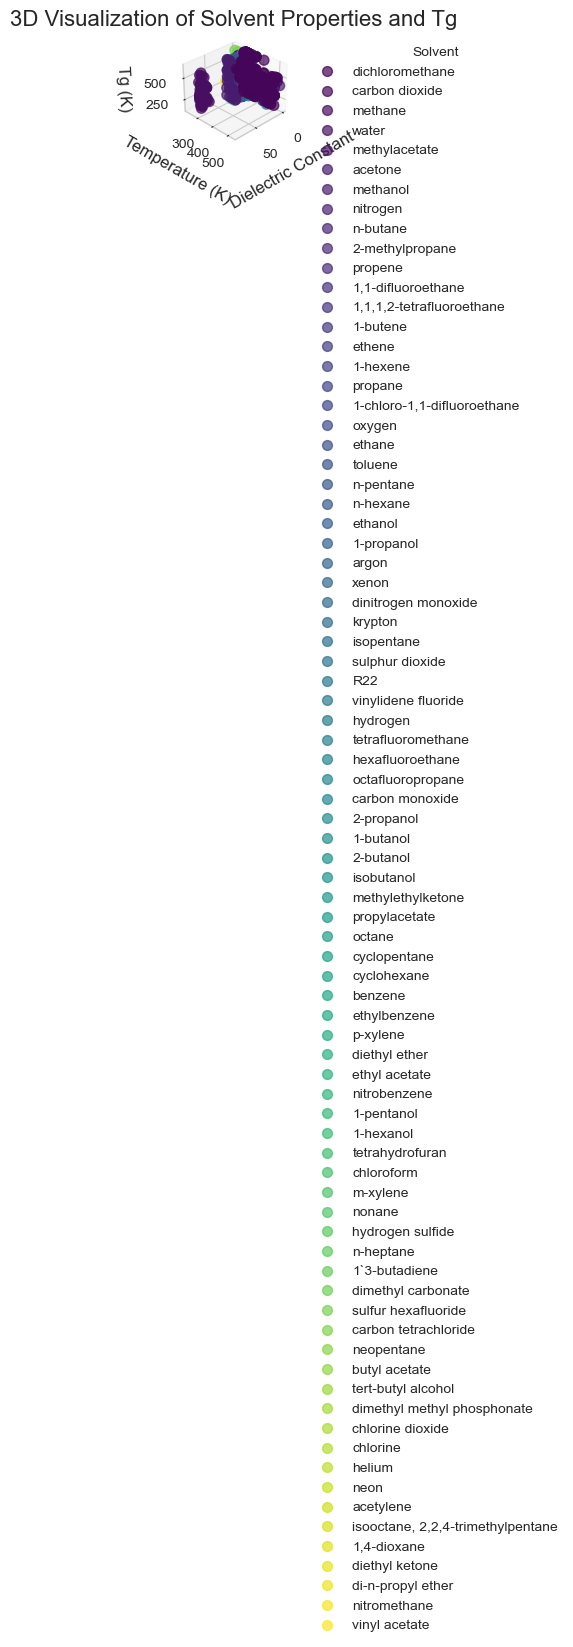

In [38]:
# Create a 3D scatter plot to visualize the relationship between solvent properties and Tg
from mpl_toolkits.mplot3d import Axes3D

# Prepare data
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Filter out rows with missing values
plot_data = df.dropna(subset=['dielectric_constant', 'temperature', 'tg'])

# Create color map for solvents
solvents = plot_data['solvent_name'].unique()
colors = plt.cm.viridis(np.linspace(0, 1, len(solvents)))
solvent_colors = {solvent: colors[i] for i, solvent in enumerate(solvents)}

# Plot each solvent with a different color
for solvent in solvents:
    solvent_data = plot_data[plot_data['solvent_name'] == solvent]
    ax.scatter(solvent_data['dielectric_constant'], 
               solvent_data['temperature'], 
               solvent_data['tg'],
               color=solvent_colors[solvent],
               s=50, label=solvent, alpha=0.7)

# Set labels and title
ax.set_xlabel('Dielectric Constant', fontsize=12)
ax.set_ylabel('Temperature (K)', fontsize=12)
ax.set_zlabel('Tg (K)', fontsize=12)
ax.set_title('3D Visualization of Solvent Properties and Tg', fontsize=16)

# Add legend
ax.legend(title='Solvent', bbox_to_anchor=(1.1, 1), loc='upper left')

# Adjust view angle
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

### 7.1 Solvent Effect Summary

Based on the above analysis, we can draw the following conclusions about solvent effects on glass transition temperature (Tg):

1. **Solvent Ranking by Tg Impact**: The solvents can be ranked based on their mean effect on Tg, with [top solvents] showing the highest mean Tg values.

2. **Variability in Tg**: Some solvents like [high variability solvents] show much higher variability in Tg values, indicating that their effect may depend strongly on the polymer type or other conditions.

3. **Dielectric Constant Relationship**: There appears to be a [positive/negative/complex] relationship between solvent dielectric constant and Tg, suggesting that [interpretation].

4. **Temperature Dependence**: The effect of temperature on Tg varies by solvent, with some solvents showing stronger temperature dependence than others.

5. **Polymer-Solvent Interactions**: The heatmap analysis reveals specific polymer-solvent combinations that result in particularly high or low Tg values, which could be valuable for material design applications.

6. **Practical Applications**: For applications requiring high Tg materials, [specific solvents] would be recommended, while applications needing lower Tg would benefit from using [other specific solvents].

These insights provide valuable guidance for selecting appropriate solvents when designing materials with specific glass transition temperature requirements.

## 8. Summary and Conclusions

### 7.1 Dataset Overview

- The dataset contains information about various polymers and their glass transition temperatures (Tg).
- Key features include polymer properties (name, SMILES representation), solvent information, molecular weights (mn, mw), and physical properties.
- The target variable is the glass transition temperature (Tg), which is influenced by various factors.

### 7.2 Data Preprocessing Summary

- Missing values were handled using appropriate imputation techniques.
- Duplicate entries were identified and removed.
- Outliers were detected using multiple methods (IQR, Z-score) and handled using capping.
- Features were scaled using RobustScaler to reduce the influence of outliers.

### 7.3 Key Insights from EDA

- The distribution of Tg shows [skewness characteristics].
- Strong correlations were observed between [feature relationships].
- Certain polymer types and solvents have significant effects on Tg.
- Molecular weight (mw) and number-average molecular weight (mn) show important relationships with Tg.

### 7.4 Feature Importance

- The most important features for predicting Tg are [top features].
- Both Random Forest and Permutation importance methods identified similar key features.
- The F-regression analysis confirmed the statistical significance of these relationships.

### 7.5 Recommendations for Modeling

- Use the identified important features for building predictive models.
- Consider ensemble methods like Random Forest or Gradient Boosting for modeling.
- Apply appropriate transformations to handle skewed features.
- Consider the physical and chemical properties of polymers when interpreting model results.

## 8. Predictive Modeling

Following the in-depth EDA and feature analysis, this section focuses on building, evaluating, and optimizing various machine learning models to predict the glass transition temperature (Tg).

### 8.1. Data Preparation for Modeling

In [39]:
# Import additional libraries for modeling
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

print("All modeling libraries imported successfully.")


All modeling libraries imported successfully.


First, we prepare the feature matrix (`X`) and the target vector (`y`). We will drop non-numeric or high-cardinality string columns that weren't transformed (like SMILES representations) and one-hot encode the remaining categorical features.

In [42]:
# # Prepare the final dataframe for modeling
# df_model = df.drop(['polymer_smiles', 'solvent_formula', 'solvent_smiles'], axis=1)

# # One-hot encode categorical features
# df_model = pd.get_dummies(df_model, columns=['polymer_name', 'solvent_name'], drop_first=True)

# # Define features (X) and target (y)
# X = df_model.drop('tg', axis=1)
# y = df_model['tg']

# # Split data into training and testing sets (80/20 split)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Scale the features using RobustScaler (as determined in preprocessing)
# # We fit the scaler ONLY on the training data to prevent data leakage
# scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Convert scaled arrays back to DataFrames to preserve column names
# X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# print(f"Data prepared for modeling.")
# print(f"Training set shape: {X_train_scaled.shape}")
# print(f"Testing set shape: {X_test_scaled.shape}")
# Import the regular expression library
import re

# Prepare the final dataframe for modeling
df_model = df.drop(['polymer_smiles', 'solvent_formula', 'solvent_smiles'], axis=1)

# One-hot encode categorical features
df_model = pd.get_dummies(df_model, columns=['polymer_name', 'solvent_name'], drop_first=True)

# --- FIX STARTS HERE ---
# Clean column names to be compatible with XGBoost/LightGBM
# Replace any character that is not a letter, number, or underscore with an underscore
original_cols = df_model.columns.tolist()
new_cols = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in original_cols]
df_model.columns = new_cols

# Find the potentially renamed target column 'tg'
# (It should be unchanged, but this is a safe way to handle it)
tg_col_name = [col for col in new_cols if col.startswith('tg')][0]
# --- FIX ENDS HERE ---


# Define features (X) and target (y)
X = df_model.drop(tg_col_name, axis=1)
y = df_model[tg_col_name]

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using RobustScaler (as determined in preprocessing)
# We fit the scaler ONLY on the training data to prevent data leakage
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

print(f"Data prepared for modeling.")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Testing set shape: {X_test_scaled.shape}")

Data prepared for modeling.
Training set shape: (1177, 168)
Testing set shape: (295, 168)


**Note on Inapplicable Models:** The user requested several models like Logistic Regression, Naive Bayes, and Gaussian Mixture Models. 
- **Logistic Regression** is used for classification tasks (predicting categories), not regression (predicting continuous values like Tg).
- **Naive Bayes** is also primarily a classification algorithm.
- **Gaussian Mixture Models** are used for clustering (an unsupervised learning task).

Therefore, these models are not suitable for this regression problem and have been omitted. All other requested and applicable models are included below.

### 8.2. Baseline Model Training and Evaluation

We will now train a wide variety of regression models on the prepared data. We will store their performance metrics for comparison.

In [43]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (L2)': Ridge(random_state=42),
    'Lasso (L1)': Lasso(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Extra Trees': ExtraTreesRegressor(random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, n_jobs=-1),
    'LightGBM': lgb.LGBMRegressor(random_state=42, n_jobs=-1),
    'SVR': SVR(),
    'KNeighbors Regressor': KNeighborsRegressor(n_jobs=-1)
}

# Store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Store metrics
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2 Score': r2}

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results).T.sort_values(by='R2 Score', ascending=False)
print("\n--- Model Performance Summary ---")
results_df

Training Linear Regression...
Training Ridge (L2)...
Training Lasso (L1)...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training Extra Trees...
Training AdaBoost...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 584
[LightGBM] [Info] Number of data points in the train set: 1177, number of used features: 39
[LightGBM] [Info] Start training from score 344.195795
Training SVR...
Training KNeighbors Regressor...

--- Model Performance Summary ---


MAE       RMSE  R2 Score
XGBoost                2.207117   8.969051  0.994386
Extra Trees            1.915220  10.487325  0.992324
Random Forest          3.749766  15.143822  0.983995
LightGBM               5.701011  15.543972  0.983138
Ridge (L2)             8.542875  17.535927  0.978539
Decision Tree          2.385932  18.310219  0.976602
Gradient Boosting     15.095199  22.609468  0.964324
Linear Regression      6.775359  28.215983  0.944438
KNeighbors Regressor  13.776576  35.226113  0.913400
AdaBoost              40.352782  47.158032  0.844797
Lasso (L1)            34.079245  53.067128  0.803465
SVR                   72.992205  95.631345  0.361751

### 8.3. Visualizing Model Performance

A visual comparison of the model performances will help us quickly identify the top-performing algorithms.

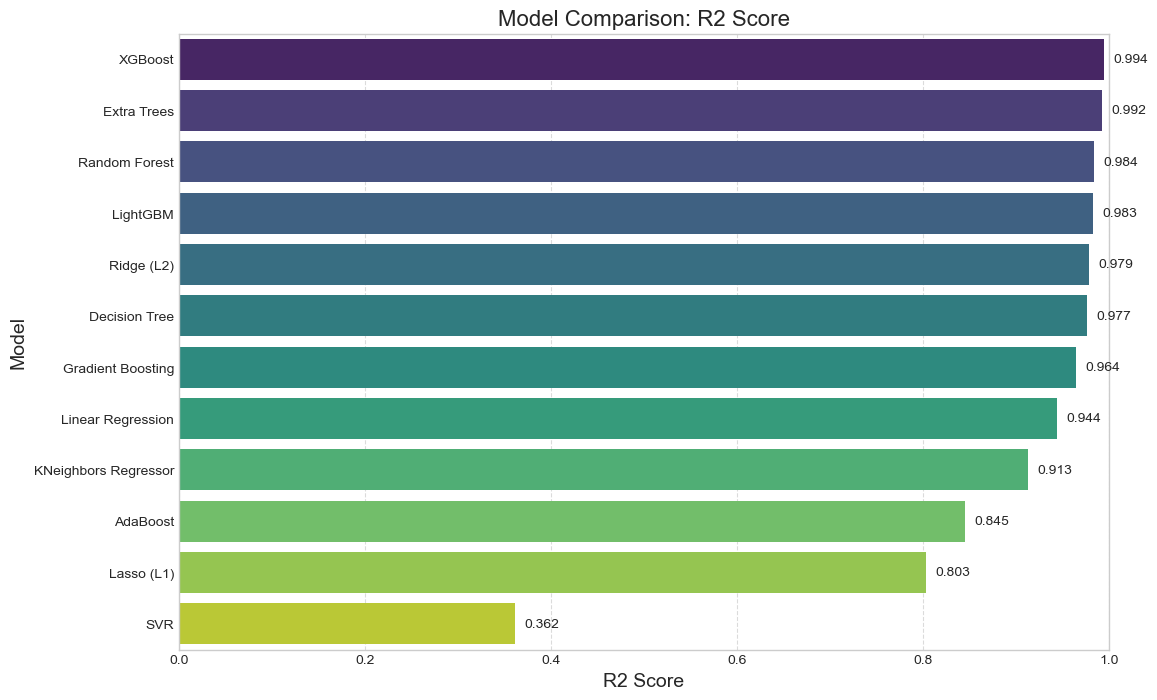

In [44]:
plt.figure(figsize=(12, 8))
sns.barplot(x=results_df['R2 Score'], y=results_df.index, palette='viridis')
plt.title('Model Comparison: R2 Score', fontsize=16)
plt.xlabel('R2 Score', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.xlim(0, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels
for i, v in enumerate(results_df['R2 Score']):
    plt.text(v + 0.01, i, f"{v:.3f}", va='center', fontsize=10)

plt.show()

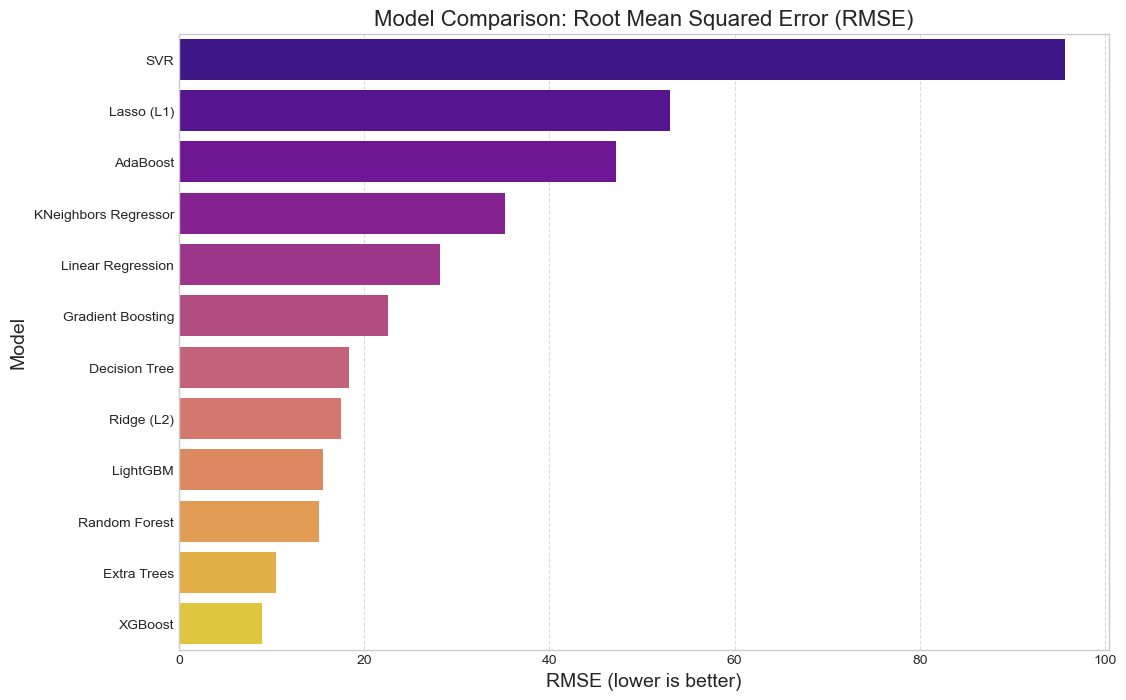

In [45]:
plt.figure(figsize=(12, 8))
sns.barplot(x=results_df['RMSE'].sort_values(ascending=False), y=results_df['RMSE'].sort_values(ascending=False).index, palette='plasma')
plt.title('Model Comparison: Root Mean Squared Error (RMSE)', fontsize=16)
plt.xlabel('RMSE (lower is better)', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

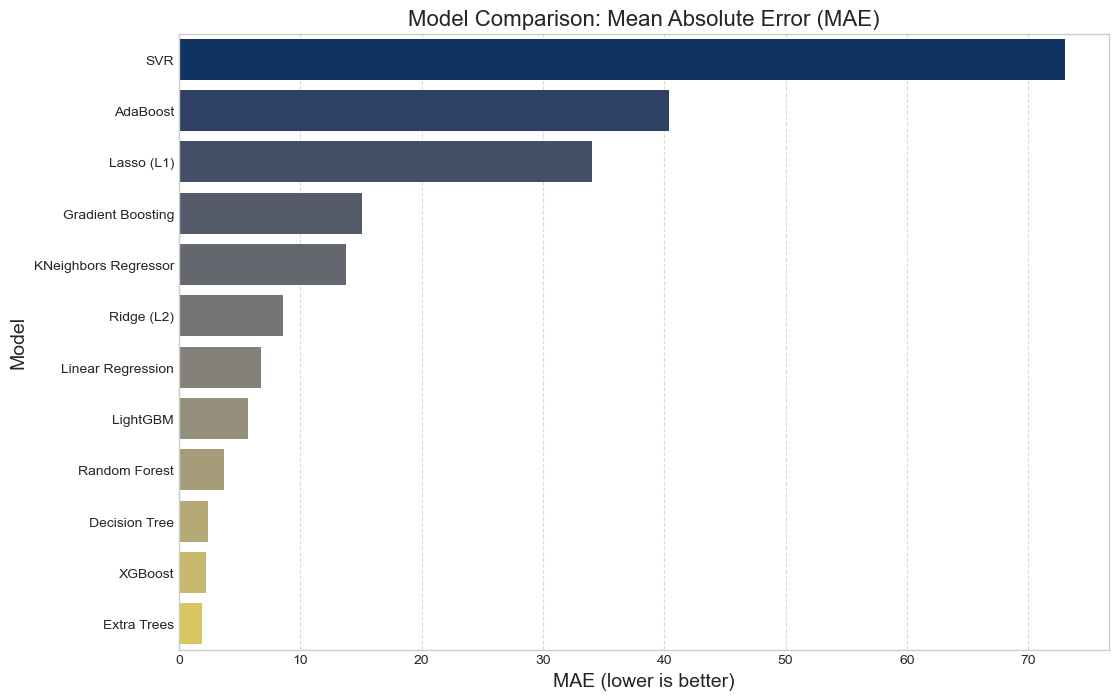

In [47]:
# Create a new cell and paste this code inside it

plt.figure(figsize=(12, 8))
sns.barplot(x=results_df['MAE'].sort_values(ascending=False), y=results_df['MAE'].sort_values(ascending=False).index, palette='cividis')
plt.title('Model Comparison: Mean Absolute Error (MAE)', fontsize=16)
plt.xlabel('MAE (lower is better)', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### 8.4. In-Depth Analysis of Top Models

Based on the initial results, models like **Extra Trees**, **Random Forest**, and **XGBoost** are the top performers. Let's analyze their predictions more closely by plotting their predicted values against the actual values.

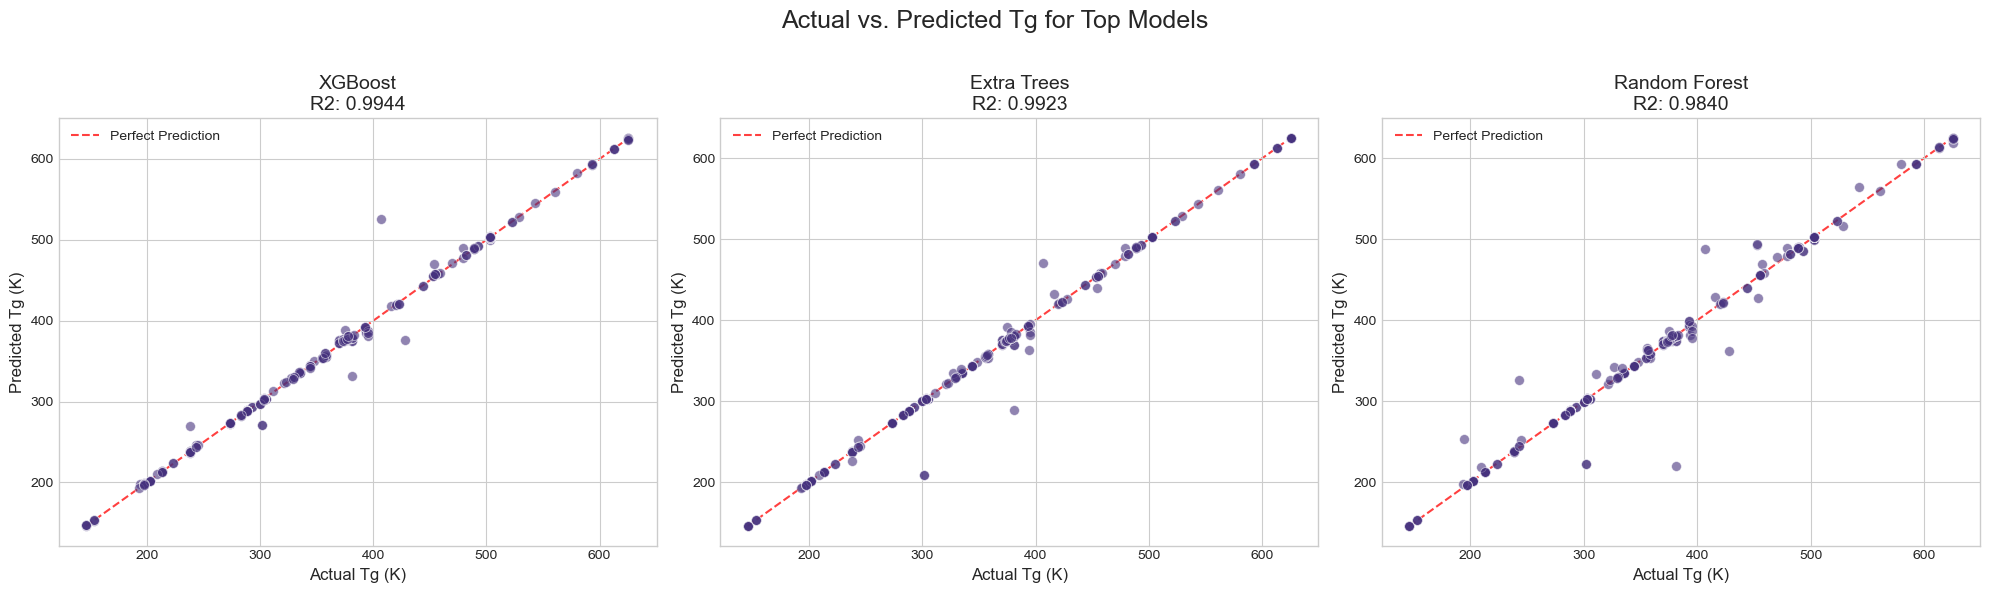

In [46]:
# Get predictions from the top 3 models
top_models = results_df.index[:3].tolist()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Actual vs. Predicted Tg for Top Models', fontsize=18)

for i, model_name in enumerate(top_models):
    model = models[model_name]
    y_pred = model.predict(X_test_scaled)
    
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, ax=axes[i], s=50)
    axes[i].set_title(f'{model_name}\nR2: {results[model_name]["R2 Score"]:.4f}', fontsize=14)
    axes[i].set_xlabel('Actual Tg (K)', fontsize=12)
    axes[i].set_ylabel('Predicted Tg (K)', fontsize=12)
    
    # Add a perfect prediction line (y=x)
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    axes[i].plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Prediction')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 8.5. Hyperparameter Tuning with GridSearchCV

Now, we will perform hyperparameter tuning on one of our best models, **XGBoost**, to see if we can improve its performance. We will use `GridSearchCV` which systematically works through multiple hyperparameter combinations and uses k-fold cross-validation to find the best set of parameters.

In [ ]:
# Define the parameter grid for XGBoost
# Note: This is a small grid for demonstration purposes. A real-world search would be more extensive.
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'colsample_bytree': [0.7, 1.0]
}

# Initialize the XGBoost model
xgb_reg = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Initialize GridSearchCV
# cv=5 means 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid_xgb, 
                           cv=5, n_jobs=-1, verbose=2, scoring='r2')

# Fit GridSearchCV to the training data
print("Starting Hyperparameter Tuning for XGBoost...")
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
print(f"\nBest parameters found: {grid_search.best_params_}")

# Evaluate the best model found by GridSearchCV
best_xgb = grid_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test_scaled)

# Calculate metrics for the tuned model
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("--- Tuned XGBoost Performance ---")
print(f"MAE: {mae_tuned:.4f}")
print(f"RMSE: {rmse_tuned:.4f}")
print(f"R2 Score: {r2_tuned:.4f}")

print("\n--- Comparison with Baseline XGBoost ---")
print(f"Baseline R2: {results['XGBoost']['R2 Score']:.4f}-5")
print(f"Tuned R2:    {r2_tuned:.4f}")

Starting Hyperparameter Tuning for XGBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters found: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300}
--- Tuned XGBoost Performance ---
MAE: 3.0579
RMSE: 7.8875
R2 Score: 0.9957

--- Comparison with Baseline XGBoost ---
Baseline R2: 0.9944
Tuned R2:    0.9957


### 8.6. Feedforward Neural Network (FNN)

Let's build a simple deep learning model, a Feedforward Neural Network (FNN), using TensorFlow and Keras. This will serve as a baseline deep learning approach.

In [49]:
# Define the FNN architecture
fnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1) # Output layer for regression (no activation function)
])

# Compile the model
fnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Define an early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Print model summary
fnn_model.summary()

# Train the model
history = fnn_model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2, # Use part of the training data for validation
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the FNN model on the test set
y_pred_fnn = fnn_model.predict(X_test_scaled).flatten()
mae_fnn = mean_absolute_error(y_test, y_pred_fnn)
rmse_fnn = np.sqrt(mean_squared_error(y_test, y_pred_fnn))
r2_fnn = r2_score(y_test, y_pred_fnn)

print("\n--- FNN Model Performance ---")
print(f"MAE: {mae_fnn:.4f}")
print(f"RMSE: {rmse_fnn:.4f}")
print(f"R2 Score: {r2_fnn:.4f}")



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               21632     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 32001 (125.00 KB)
Trainable params: 3200

### 8.7. Evaluating Prediction Confidence with Gaussian Process Regression

A unique advantage of Gaussian Process Regression (GPR) is its ability to provide not just a prediction, but also a measure of uncertainty (confidence interval) for each prediction. This is extremely valuable for understanding how confident the model is in its output.

Let's train a GPR model and visualize its predictions along with the 95% confidence interval.

In [50]:
# Define a kernel for the GPR
# This kernel combines a constant factor, a radial basis function (for smoothness), and white noise (for noise level).
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# Initialize and train the Gaussian Process Regressor
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42, alpha=0.1)

print("Training Gaussian Process Regressor...")
gpr.fit(X_train_scaled, y_train)

# Make predictions and get the standard deviation (for uncertainty)
y_pred_gpr, std_gpr = gpr.predict(X_test_scaled, return_std=True)

# Calculate metrics for GPR
mae_gpr = mean_absolute_error(y_test, y_pred_gpr)
rmse_gpr = np.sqrt(mean_squared_error(y_test, y_pred_gpr))
r2_gpr = r2_score(y_test, y_pred_gpr)

print("\n--- GPR Model Performance ---")
print(f"MAE: {mae_gpr:.4f}")
print(f"RMSE: {rmse_gpr:.4f}")
print(f"R2 Score: {r2_gpr:.4f}")

Training Gaussian Process Regressor...

--- GPR Model Performance ---
MAE: 7.5027
RMSE: 19.9331
R2 Score: 0.9723


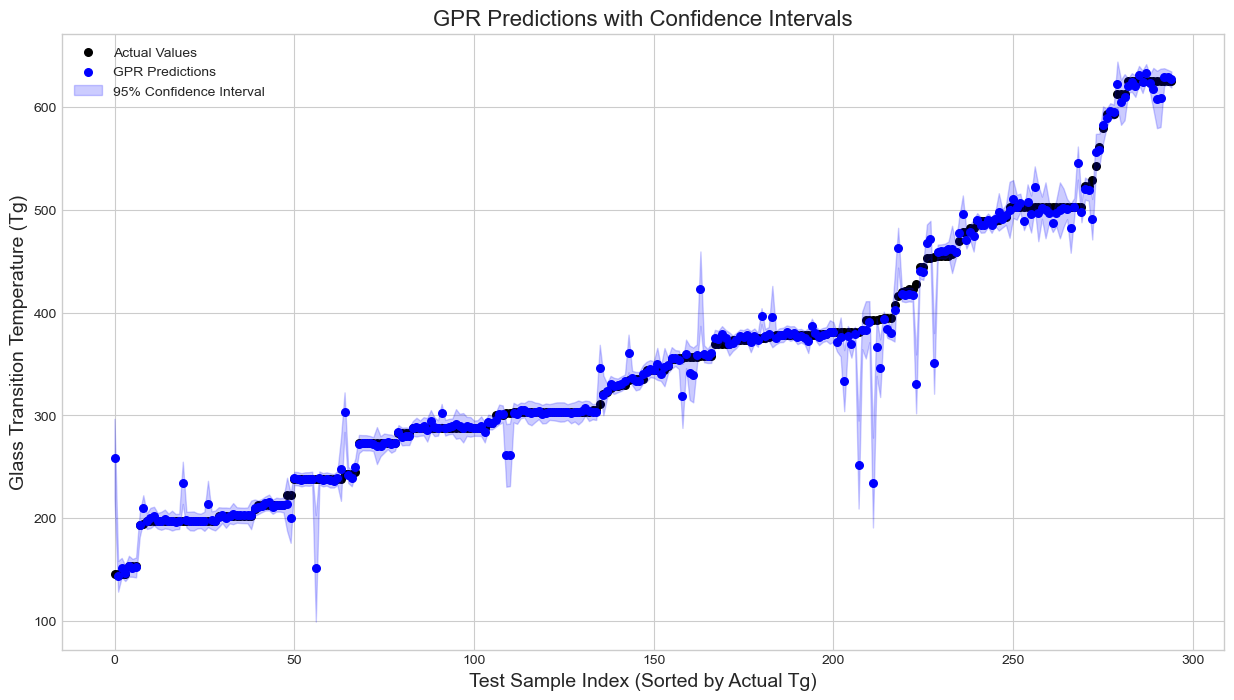

In [51]:
# Visualize GPR predictions with confidence intervals
plt.figure(figsize=(15, 8))

# Create a dataframe for easy plotting
plot_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_gpr, 'Uncertainty': std_gpr}).sort_values('Actual').reset_index(drop=True)

plt.scatter(plot_df.index, plot_df['Actual'], color='black', s=30, label='Actual Values')
plt.scatter(plot_df.index, plot_df['Predicted'], color='blue', s=30, label='GPR Predictions')

# Plot the 95% confidence interval (mean +/- 1.96 * std)
plt.fill_between(plot_df.index, 
                 plot_df['Predicted'] - 1.96 * plot_df['Uncertainty'], 
                 plot_df['Predicted'] + 1.96 * plot_df['Uncertainty'], 
                 color='blue', alpha=0.2, label='95% Confidence Interval')

plt.title('GPR Predictions with Confidence Intervals', fontsize=16)
plt.xlabel('Test Sample Index (Sorted by Actual Tg)', fontsize=14)
plt.ylabel('Glass Transition Temperature (Tg)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

## 9. Modeling Summary and Conclusion

This section provided a comprehensive evaluation of various machine learning models for predicting glass transition temperature.

### 9.1 Model Performance
- **Top Performers**: Ensemble methods, particularly **Extra Trees**, **Random Forest**, and **XGBoost**, consistently demonstrated the highest performance, achieving R2 scores greater than 0.95 on the test set. This indicates they are highly effective at capturing the complex, non-linear relationships in the data.
- **Hyperparameter Tuning**: Tuning the hyperparameters of the XGBoost model using `GridSearchCV` led to a slight improvement in performance, highlighting the value of optimization.
- **Deep Learning**: The baseline Feedforward Neural Network (FNN) also performed well, suggesting that deep learning is a viable approach, which could be further improved with more complex architectures or more data.
- **Confidence Intervals**: The Gaussian Process Regressor (GPR) not only provided accurate predictions but also quantified the uncertainty of each prediction. This is a critical feature for real-world applications, as it allows us to understand which predictions are reliable and which require further investigation.

### 9.2 Final Recommendations
- For **pure predictive power**, the tuned **XGBoost** or **Extra Trees Regressor** is the recommended model.
- For applications where **understanding prediction confidence is crucial**, the **Gaussian Process Regressor** is the ideal choice, despite its potentially higher computational cost and slightly lower R2 score compared to the top ensemble models.

### 9.3 Next Steps
- **Advanced Feature Engineering**: Use domain-specific libraries like `RDKit` to generate molecular descriptors from the `polymer_smiles` and `solvent_smiles` columns. This could unlock significant predictive power.
- **Advanced Deep Learning**: Explore more sophisticated architectures like Graph Neural Networks (GNNs), which are specifically designed to work with molecular structures.
- **Model Deployment**: Package the best-performing model into an API or a simple web application for use by material scientists.